# TP 3: Overfitting et surparamétrisation

Besbes Ines & Rool Sara, 4 ModIA

# Random ReLU features

La fonction $\phi_d (x) = \max (x − b_d, 0)$ est une variante de la fonction d'activation ReLU. La ReLU standard est définie comme max(x, 0), donc $\phi_d (x) $ est une ReLU décalée horizontalement par $b_d$.

La fonction $h$ est une somme pondérée de fonctions ReLU décalées. Chaque terme $w_d \times \phi_d (x)$ représente une ReLU décalée, pondérée par un facteur $w_d$.
C'est une fonction affine par morceau.
Les poids $w_k$ déterminent l'importance ou l'influence de chaque fonction ReLU décalée dans la somme.

Si $x$ est un vecteur dans  $R^P$ et $\phi_d (x)$ est définie comme $\max (⟨x, v_d⟩ − b_d, 0)$ où $⟨x, v_d⟩$ est le produit scalaire de $x$ et $v_d$, et $v_d$ est un vecteur sur la sphère unité, alors la fonction $h$ prend une forme légèrement différente.
Dans ce cas, chaque $\phi_d (x)$ est une ReLU appliquée à une combinaison linéaire des entrées, décalée par $b_d$. Cela signifie que chaque ReLU est "orientée" différemment dans l'espace d'entrée, en fonction de $v_d$.
La fonction $h$ devient alors une somme pondérée de ces ReLUs orientées, où chaque terme est de la forme  $w_d \times \max (⟨x, v_d⟩ − b_d, 0)$.

# Mise en place sous Pytorch

## Initialisation

In [34]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm.auto import tqdm

CUDA est une plateforme de calcul parallèle. Si un GPU compatible CUDA est disponible, torch.cuda.is_available() retournera True. Cela permettra d'accélérer les calculs.

In [123]:
use_cuda=torch.cuda.is_available()
use_cuda=0
device = torch.device("cuda" if use_cuda else "cpu") 
if use_cuda :
    dtype = torch.cuda.FloatTensor
    dtype = torch.float64
else:
    dtype = torch.FloatTensor
    dtype = torch.float64
print("GPU: ", use_cuda)
factory_kwargs = {'device': device, 'dtype': dtype}
print("factory_kwargs: ", factory_kwargs)

GPU:  0
factory_kwargs:  {'device': device(type='cpu'), 'dtype': torch.float64}


In [124]:
torch.manual_seed(42)

## Création des données

In [132]:
# The function to learn
def f(x):
    return torch.abs(x) * torch.sin(2*2*torch.pi * x)

Text(0.5, 1.0, 'True function to estimate')

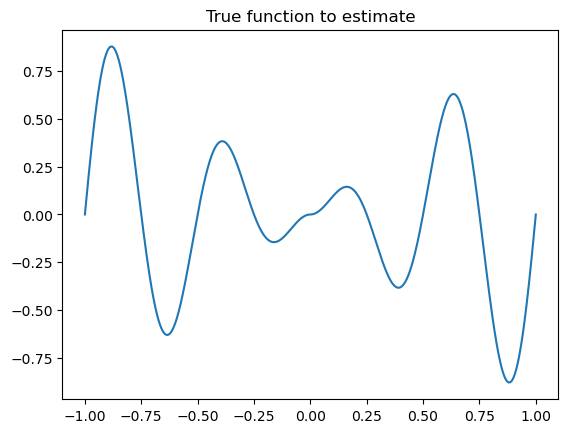

In [133]:
M = 1000 #nombre de point pour afficher la fonction
x_espace = torch.linspace(-1,1,M)
plt.plot(x_espace, f(x_espace))
plt.title("True function to estimate")

## Opérations sur le tenseur

L'opération A+B fait un broadcasting où le plus petit tenseur A est étendu (broadcasted) à la forme du plus grand tenseur B. Dans ce cas, chaque élément de A est additionné à l'élément correspondant de B.

Alors que l'autre opération ajout une nouvelle dimension à A et à B tel que :
A[:, None] ajoute une nouvelle dimension à A, transformant A de la forme (3, 1) à (3, 1, 1).
B[None, :] ajoute une nouvelle dimension à B, transformant B de la forme (1, 4) à (1, 1, 4).

Après cela, le broadcasting s'applique, étendant automatiquement les dimensions de la plus petite forme pour correspondre à la plus grande forme, et l'addition est effectuée élément par élément.

On appelle ça la diffusion c'est un mécanisme puissant qui simplifie l'expression des opérations entre des tenseurs de formes différentes en étendant automatiquement les dimensions selon certaines règles.

In [134]:
A = torch.tensor([[1.0], [2.0], [3.0]])
print(A)

B = torch.tensor([[1.0, 2.0, 3.0, 4.0]])
print(B)

AplusB = A + B
print(AplusB)

AplusB2 = A[:,None] + B[None,:]
print(AplusB2)


tensor([[1.],
        [2.],
        [3.]])
tensor([[1., 2., 3., 4.]])
tensor([[2., 3., 4., 5.],
        [3., 4., 5., 6.],
        [4., 5., 6., 7.]])
tensor([[[2., 3., 4., 5.]],

        [[3., 4., 5., 6.]],

        [[4., 5., 6., 7.]]])


## Paramètres pour estimer la fonction

Text(0.5, 1.0, 'Data')

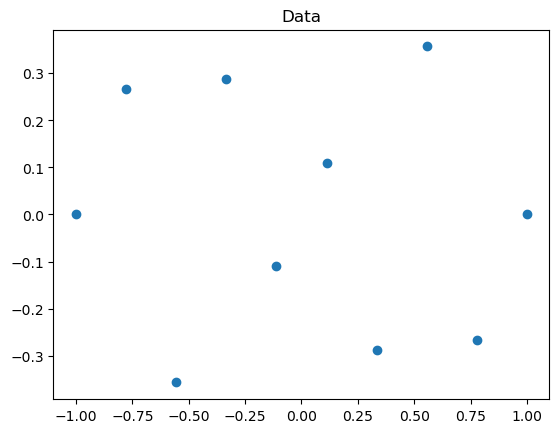

In [135]:
# données initiales
N = 10
x_test = torch.linspace(-1,1,N)
y_test = f(x_test)
plt.scatter(x_test, (y_test))
plt.title("Data")

## Implémentation du réseau de neurones

RandomReLU implémente un réseau de neurones à 1 couche avec des biais aléatoires et une fonction d'activation ReLU.
- n_hidden est le nombre de neurones qu'on fera varier
- self.weight = torch.nn.Parameter(torch.zeros(n_hidden)) correspond au poid de chaque neurone.
- dif = x - self.b[None, :], cette ligne permet de calculer la différence entre l'entrée $x$ et le biais. On utilise le broadcasting pour assurer une soustraction correcte.
- le résultat de notre fonction est un tenseur où chaque élement correspond à la sortie de notre réseau de neurones pour chaque batch $x$.


In [136]:
class RandomReLU(nn.Module):
    def __init__(self, n_hidden = 10):
        super().__init__()
        self.b = 2 * (torch.rand(n_hidden)-0.5).to(device)
        self.weight = torch.nn.Parameter(torch.zeros(n_hidden))

    def forward(self, x):
        dif = x - self.b[None, :]
        hidden = torch.maximum(dif, torch.zeros_like(dif))
        
        return torch.sum(self.weight[None, :] * hidden, dim=1)

In [137]:
n_hidden = 1000 # Defining the model     
model1 = RandomReLU(n_hidden = 1000)

In [138]:
#fonction qui nous retourne le nombre de paramètre
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of parameters: ", count_parameters(model1))

Number of parameters:  1000


## Choix de l'optimiseur

Nous choisissons l'algorithme Adam car il est plus efficace et rapide que les autres en terme convergence.

In [139]:
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model1.parameters(), lr=0.001, betas=(0.9, 0.999))

## Test de notre modèle

Nous testons notre modèle pour vérifier qu'il fonctionne. Nous étudierons plus précisement dans la suite du rapport. Nous avons commenté le code pour expliquer chaque étape.

In [140]:
niter_train = 10000 #nombre d'itération pour entrainer
batch_size = 10 #la taille de notre batch
loss_tracking = [] #tableau pour stocker le risque empirique

  0%|          | 0/10000 [00:00<?, ?it/s]

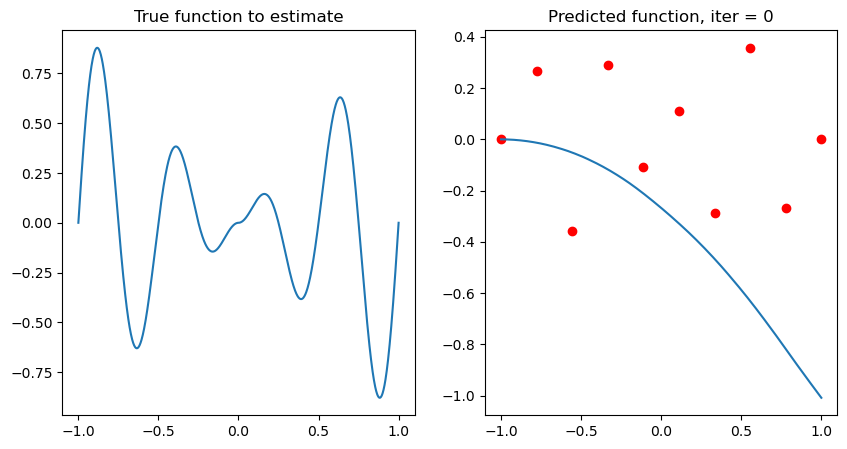

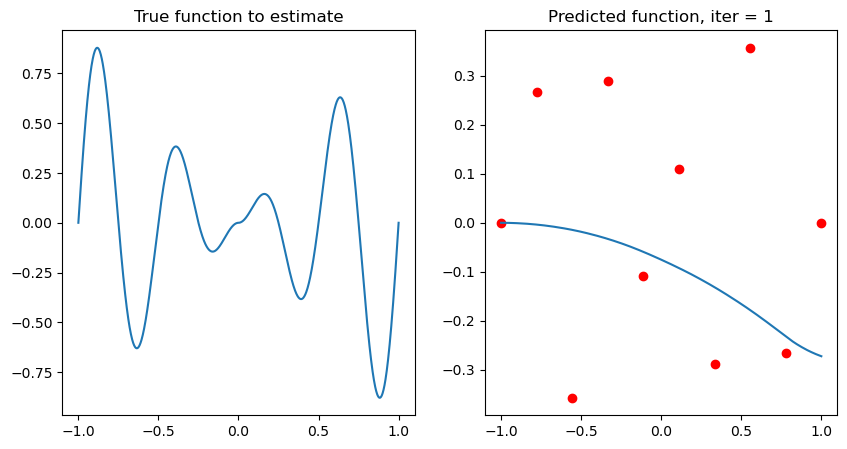

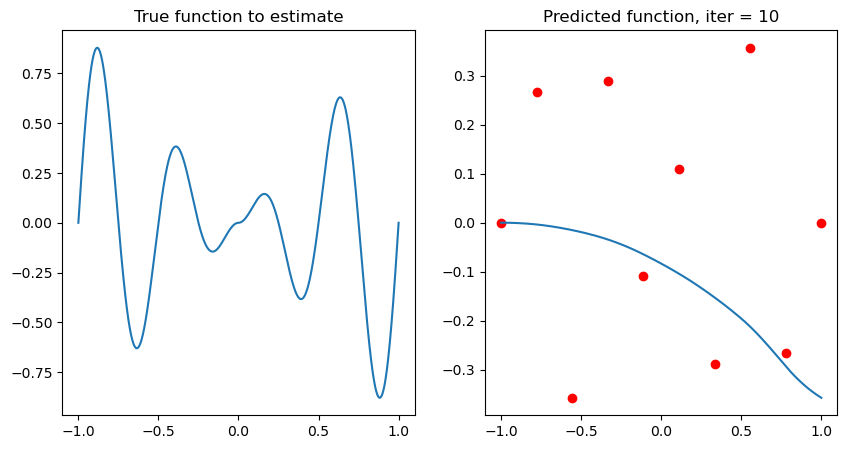

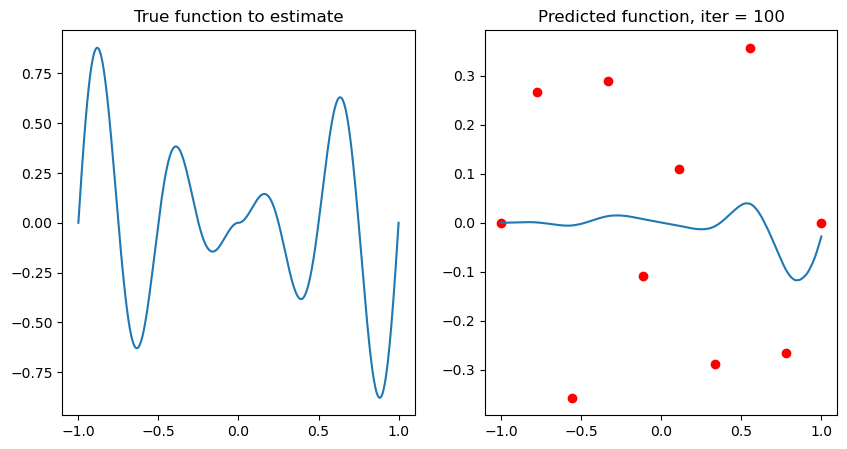

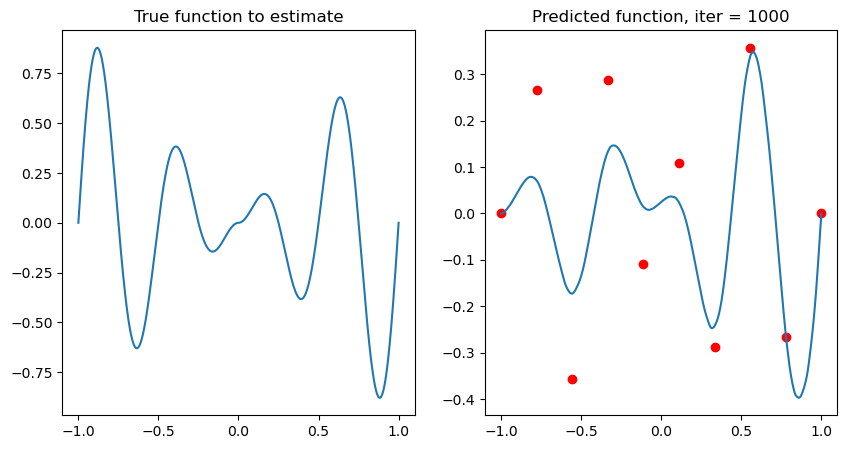

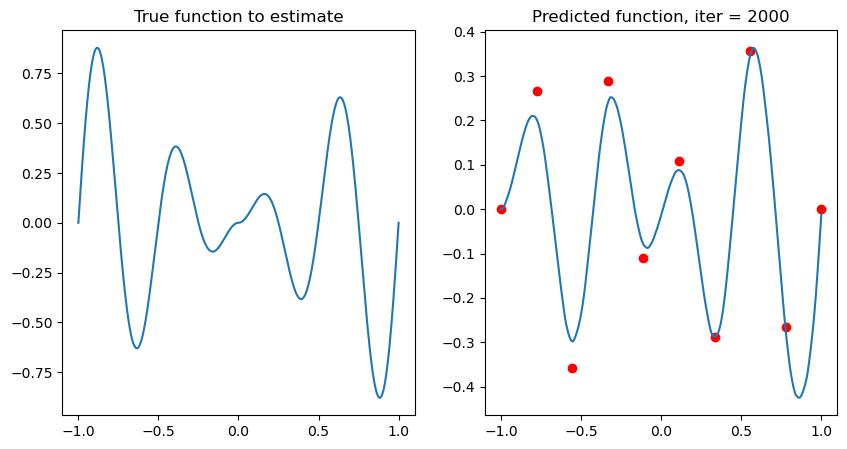

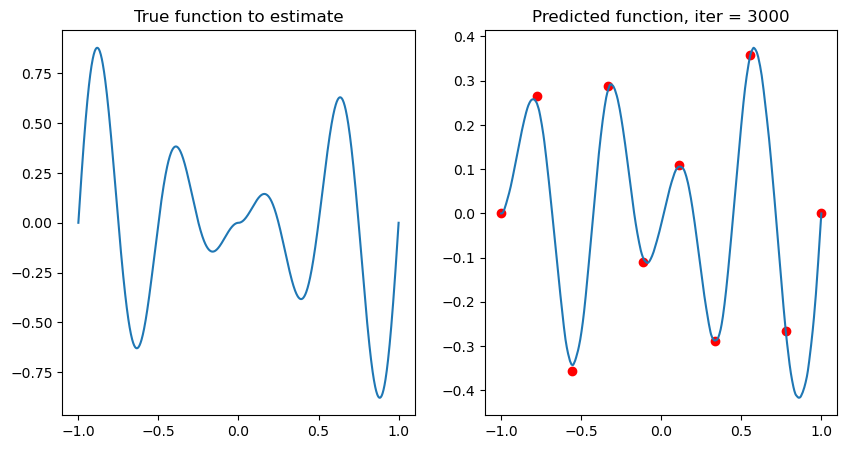

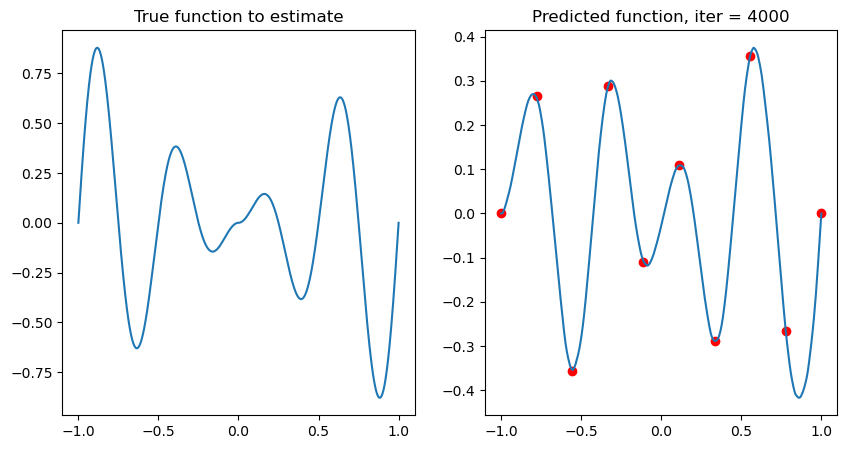

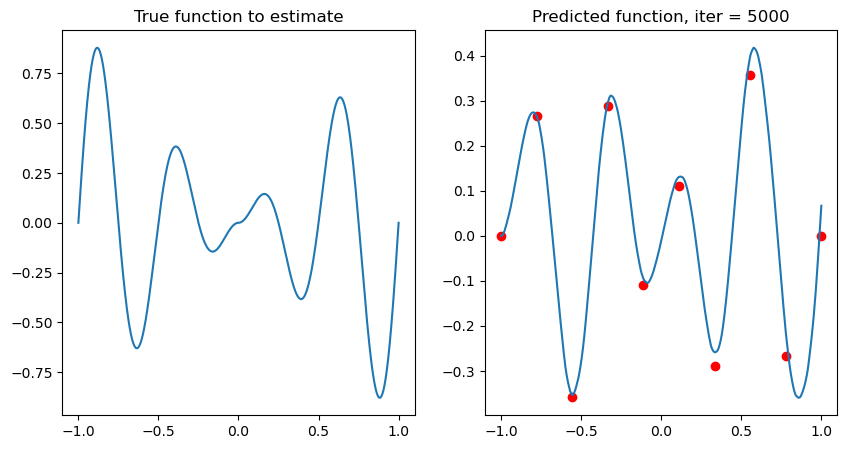

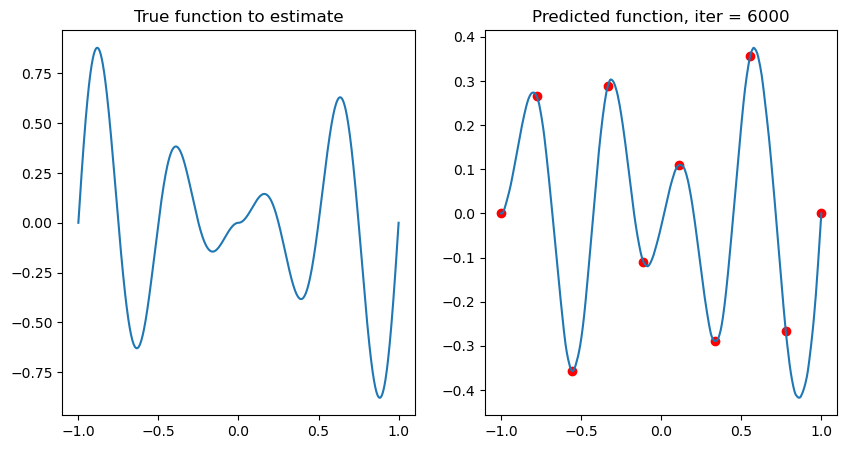

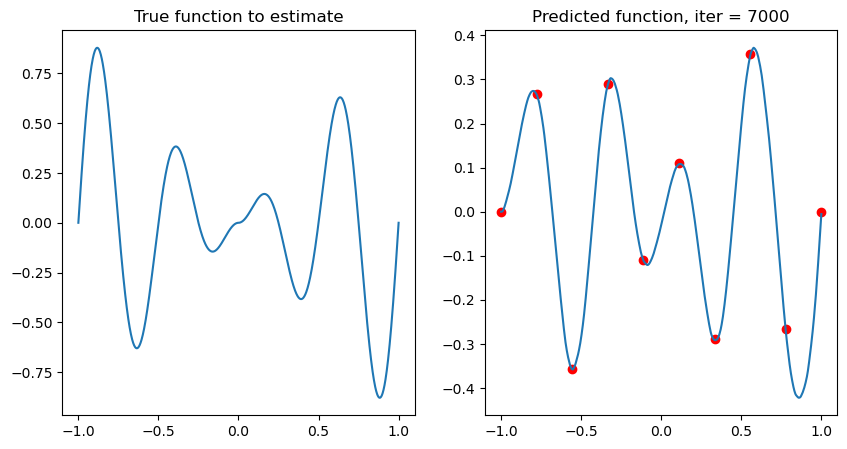

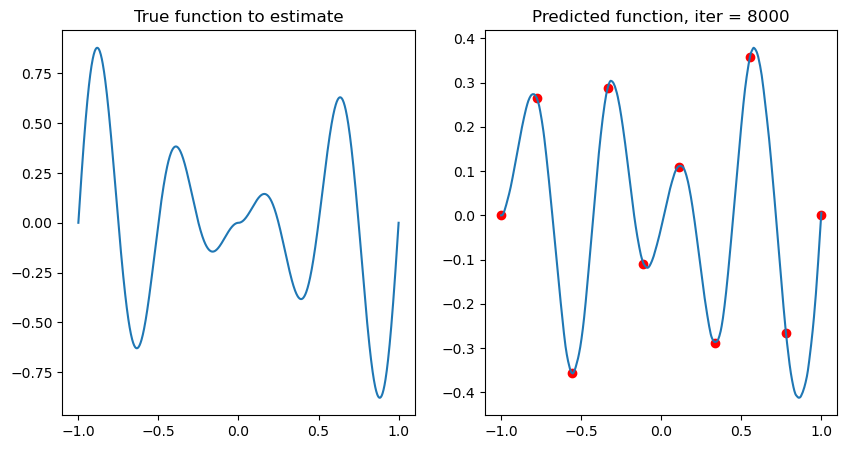

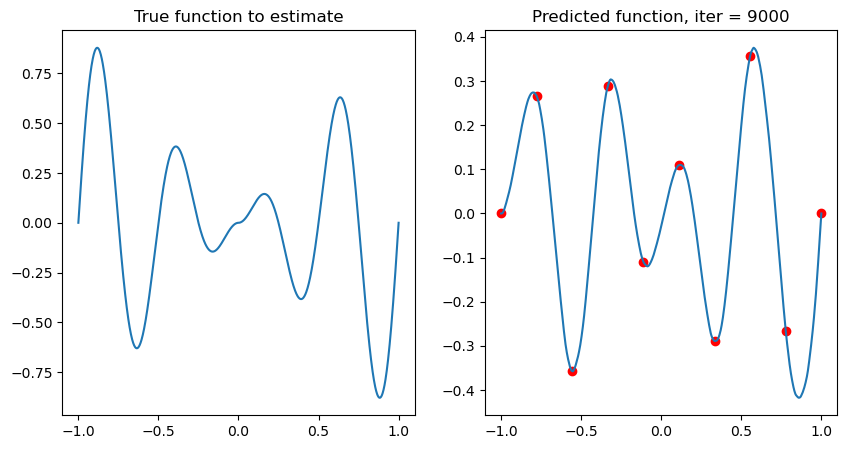

In [141]:
t = tqdm(range(niter_train))
for i in t: #boucle d'entrainement
    if batch_size>=N:
        x_batch = x_test[:,None] # On garde toute les données
        y_batch = y_test[:,]
    else:
        # on choisit un batch random
        idx = torch.randint(0, len(x_test),(batch_size,))
        x_batch = x_test[idx, None]
        y_batch = y_test[idx, ]

    optimizer.zero_grad() #initialisation de l'optimiseur

    y_pred = model1(x_batch) #fonction de prédiction
    loss = torch.mean((y_pred - y_batch)**2) #fonction perte quadratique entre les prédictions et les vraies valeurs sur un batch
    loss.backward() #calcul des gradients
    optimizer.step() #mise à jour des paramètres en fonction des gradients
    loss_tracking.append(loss.item()) #ajout à la liste

    #Affichage
    if i == 1:
        with torch.no_grad():
            fig, axs = plt.subplots(1, 2, figsize=(10,5))
            axs[0].plot(x_espace.cpu().numpy(), f(x_espace).cpu().numpy())
            axs[0].set_title("True function to estimate")
            axs[1].plot(x_espace.cpu().numpy(), model1(x_espace[:,None]).cpu().numpy())
            axs[1].scatter(x_batch.cpu().numpy(), y_batch.cpu().numpy(), color='red')
            axs[1].set_title("Predicted function, iter = " + str(i))
            plt.show()
    if i == 10:
        with torch.no_grad():
            fig, axs = plt.subplots(1, 2, figsize=(10,5))
            axs[0].plot(x_espace.cpu().numpy(), f(x_espace).cpu().numpy())
            axs[0].set_title("True function to estimate")
            axs[1].plot(x_espace.cpu().numpy(), model1(x_espace[:,None]).cpu().numpy())
            axs[1].scatter(x_batch.cpu().numpy(), y_batch.cpu().numpy(), color='red')
            axs[1].set_title("Predicted function, iter = " + str(i))
            plt.show()
    if i == 100:
        with torch.no_grad():
            fig, axs = plt.subplots(1, 2, figsize=(10,5))
            axs[0].plot(x_espace.cpu().numpy(), f(x_espace).cpu().numpy())
            axs[0].set_title("True function to estimate")
            axs[1].plot(x_espace.cpu().numpy(), model1(x_espace[:,None]).cpu().numpy())
            axs[1].scatter(x_batch.cpu().numpy(), y_batch.cpu().numpy(), color='red')
            axs[1].set_title("Predicted function, iter = " + str(i))
            plt.show()
    if i% 1000 == 0:
        with torch.no_grad():
            fig, axs = plt.subplots(1, 2, figsize=(10,5))
            axs[0].plot(x_espace.cpu().numpy(), f(x_espace).cpu().numpy())
            axs[0].set_title("True function to estimate")
            axs[1].plot(x_espace.cpu().numpy(), model1(x_espace[:,None]).cpu().numpy())
            axs[1].scatter(x_batch.cpu().numpy(), y_batch.cpu().numpy(), color='red')
            axs[1].set_title("Predicted function, iter = " + str(i))
            plt.show()

#Affichage de la fonction perte
#plt.figure()
#plt.plot(loss_tracking)
#plt.title("Risque empirique")

## Remarques

- On affiche en rouge nos points de batch nous permettant de retrouver la fonction à estimer.
- Au début de l'entrainement, nos résultats ne sont pas bons ce qui est normal. Le réseau de neurones a besoin de plusieurs itérations pour estimer la fonctione et apprendre.
- On constate la création d'oscillations au fil des itérations en se rapprochant de plus en plus des points.
- A partir de 3000 itérations, nous avons un résultat satisfaisant.
- Cependant, nous n'avons pas certaines caractéristiques de la fonction de base (comme la "bosse" autour de 0). C'est normal, il nous faudrait plus de points initaux.

# Analyse des régimes

## Fonction d'affichage

In [176]:
def regime(n_hidden):
    N = 10
    x_test = torch.linspace(-1,1,N)
    y_test = f(x_test)
    model1 = RandomReLU(n_hidden = n_hidden)
    optimizer = optim.Adam(model1.parameters(), lr=0.001, betas=(0.9, 0.999))
    niter_train = 10000
    batch_size = 10
    loss_tracking = []
    t = tqdm(range(niter_train))
    for i in t:
        
        if batch_size>=N:
            x_batch = x_test[:,None] 
            y_batch = y_test[:,]
        else:
            idx = torch.randint(0, len(x_test),(batch_size,))
            x_batch = x_test[idx, None]
            y_batch = y_test[idx, ]

        optimizer.zero_grad()
        y_pred = model1(x_batch)
        loss = torch.mean((y_pred - y_batch)**2)
        loss.backward()
        optimizer.step()
        loss_tracking.append(loss.item())

        if i% 1000 == 0:
            with torch.no_grad():
                fig, axs = plt.subplots(1, 2, figsize=(10,5))
                axs[0].plot(x_espace.cpu().numpy(), f(x_espace).cpu().numpy())
                axs[0].set_title("True function to estimate")
                axs[1].plot(x_espace.cpu().numpy(), model1(x_espace[:,None]).cpu().numpy())
                axs[1].scatter(x_batch.cpu().numpy(), y_batch.cpu().numpy(), color='red')
                axs[1].set_title("Predicted function, n_iter = " + str(i))
                plt.show()

    #plt.figure()
    #plt.plot(loss_tracking)
    #plt.title("Loss function")


## Régime sous-paramétré

  0%|          | 0/10000 [00:00<?, ?it/s]

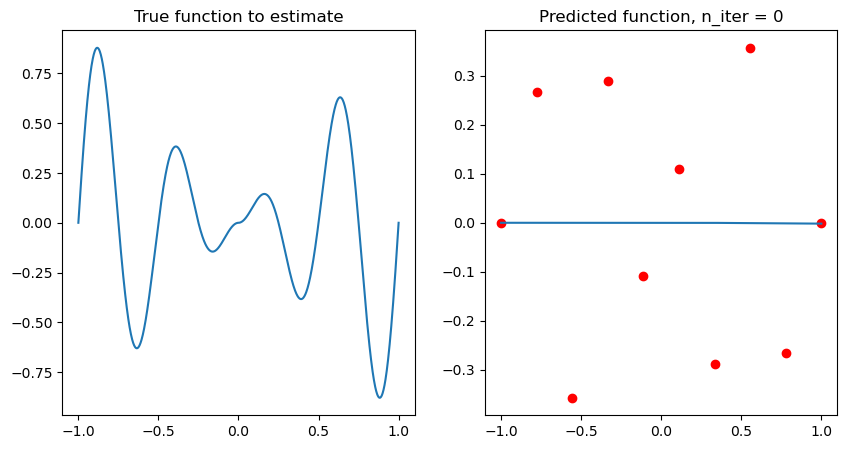

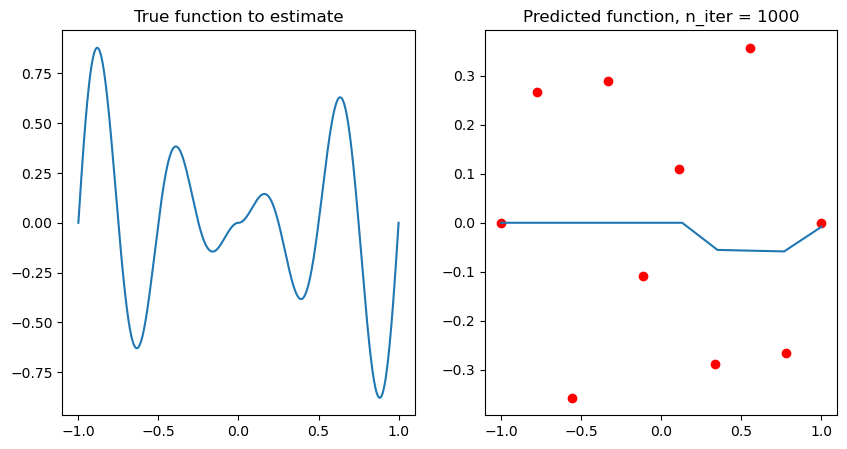

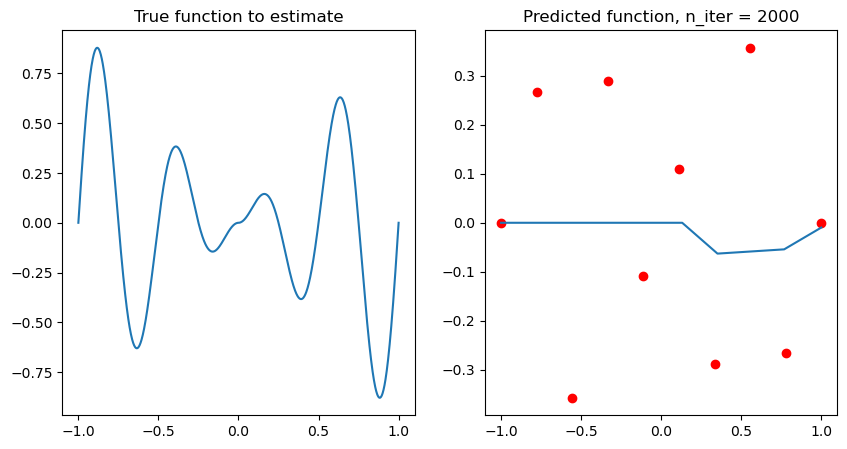

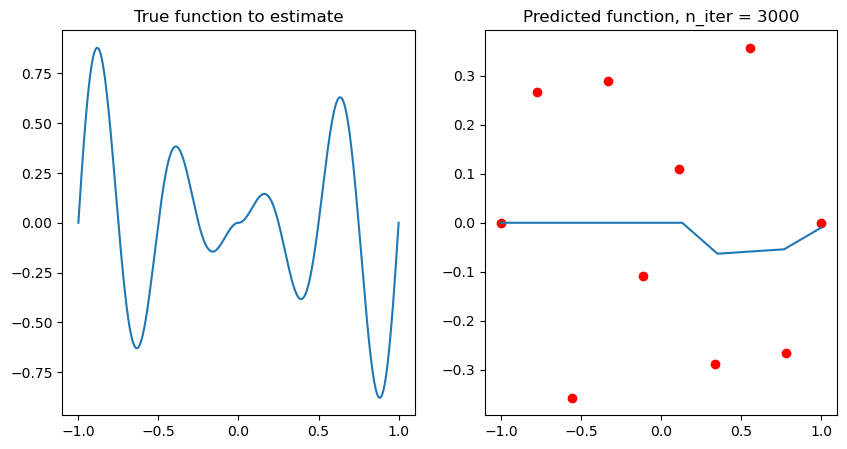

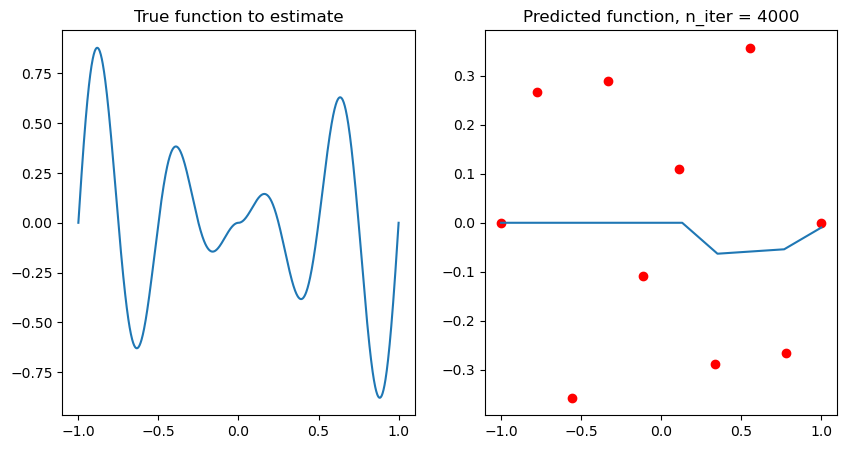

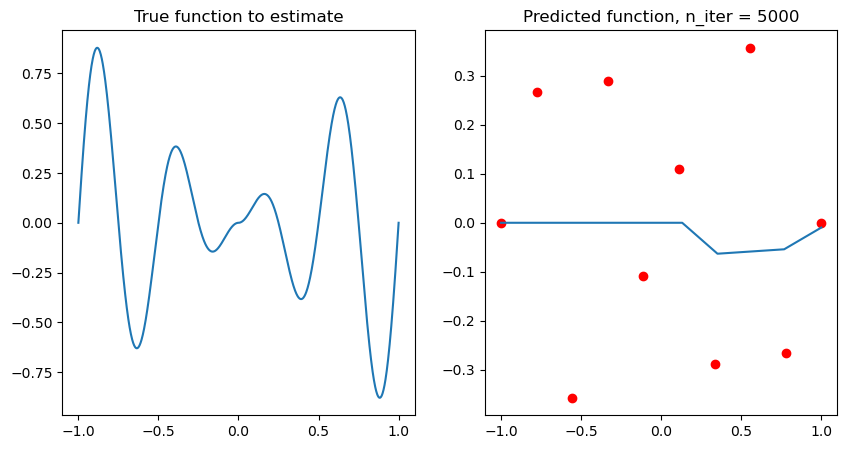

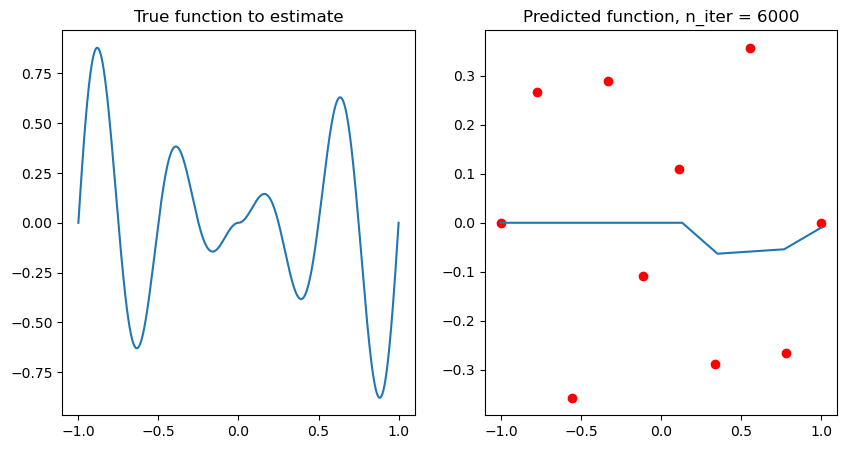

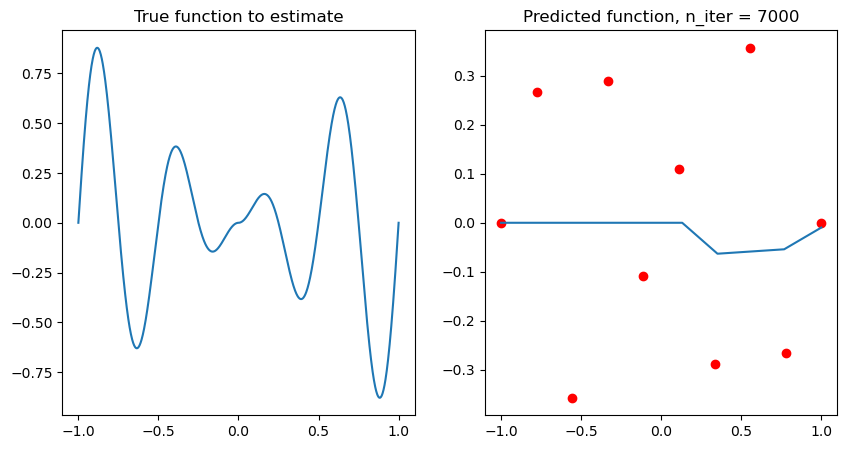

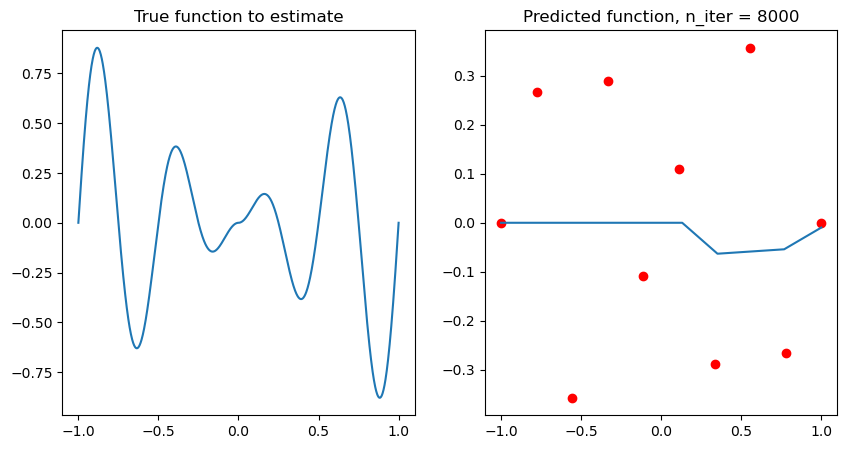

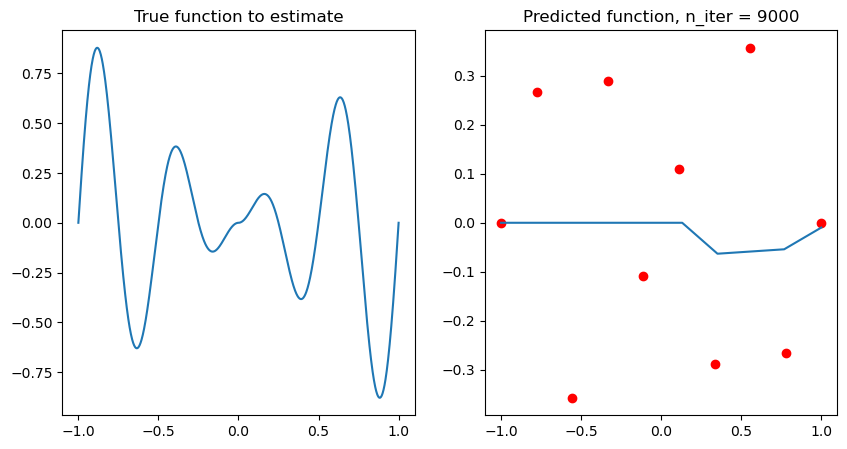

In [177]:
regime(3)

  0%|          | 0/10000 [00:00<?, ?it/s]

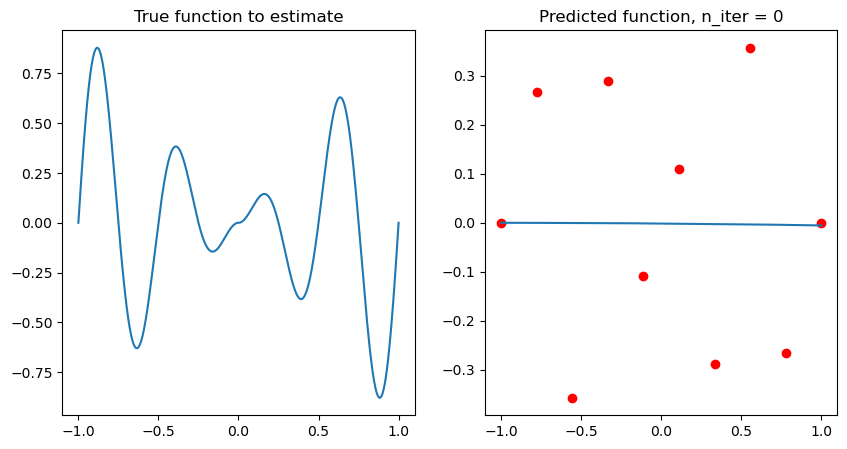

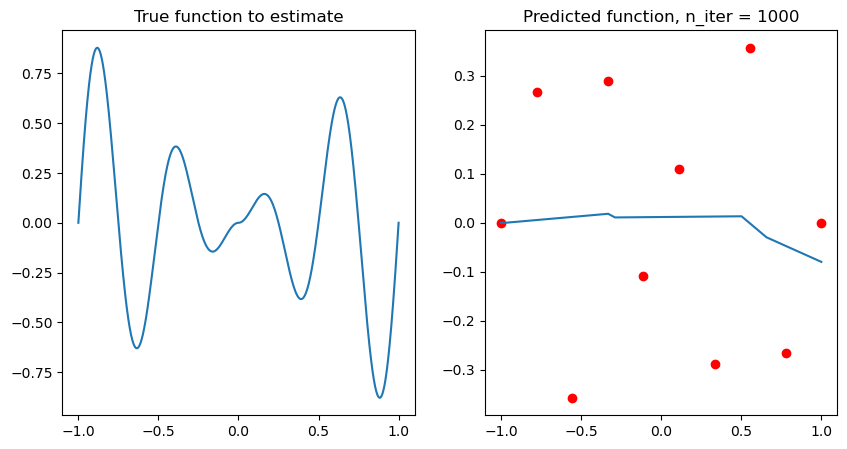

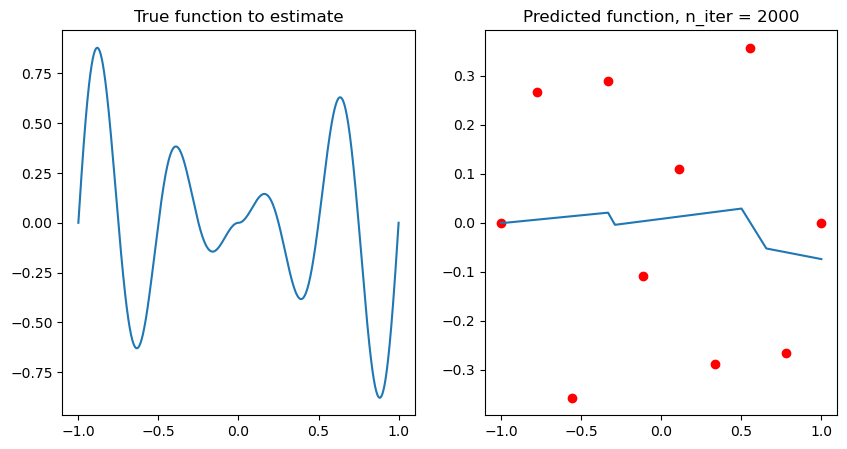

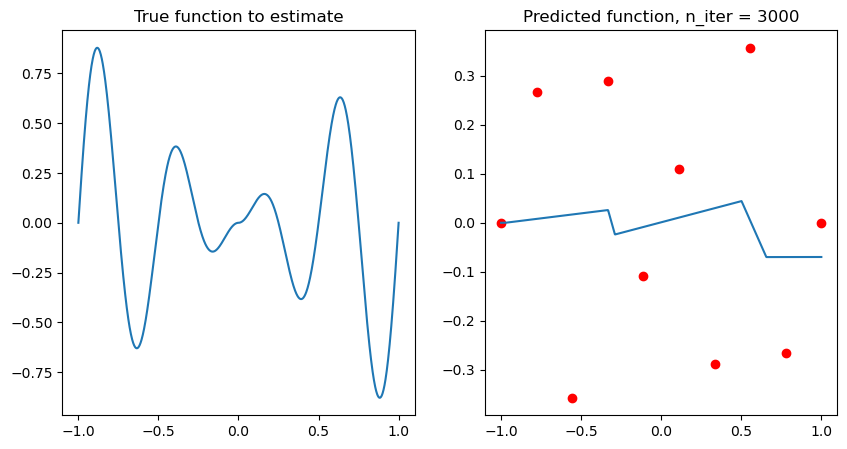

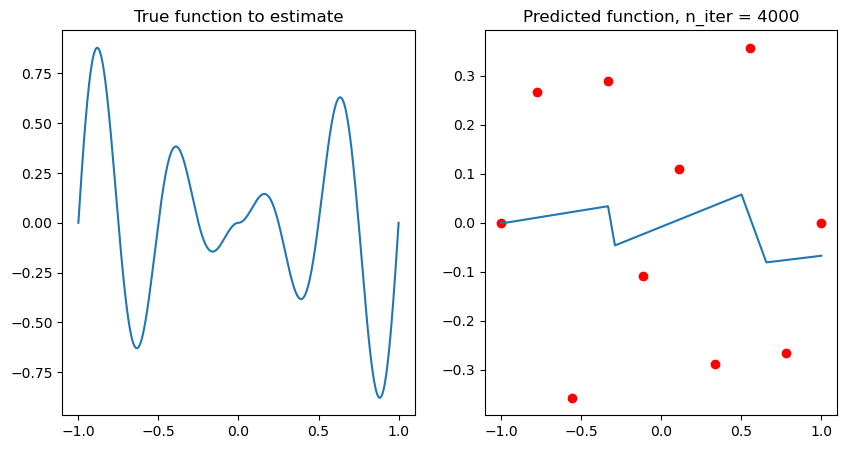

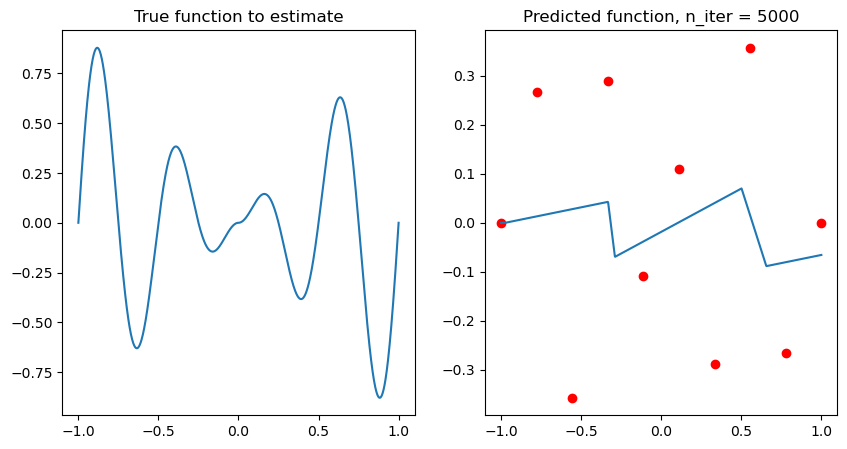

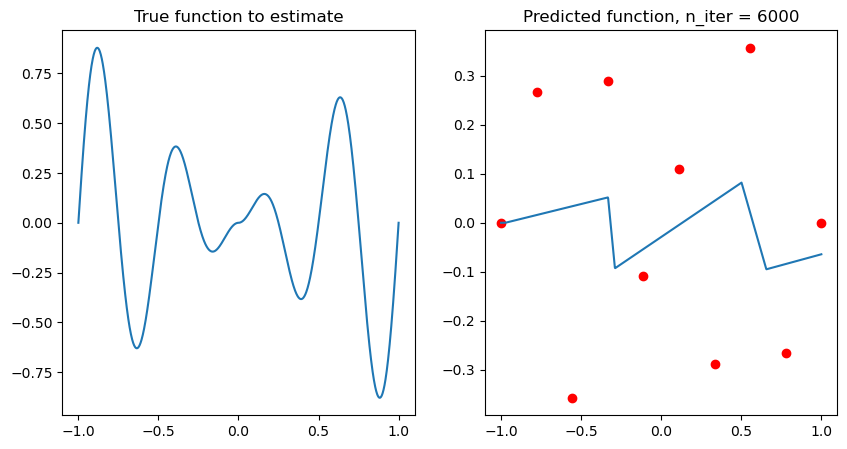

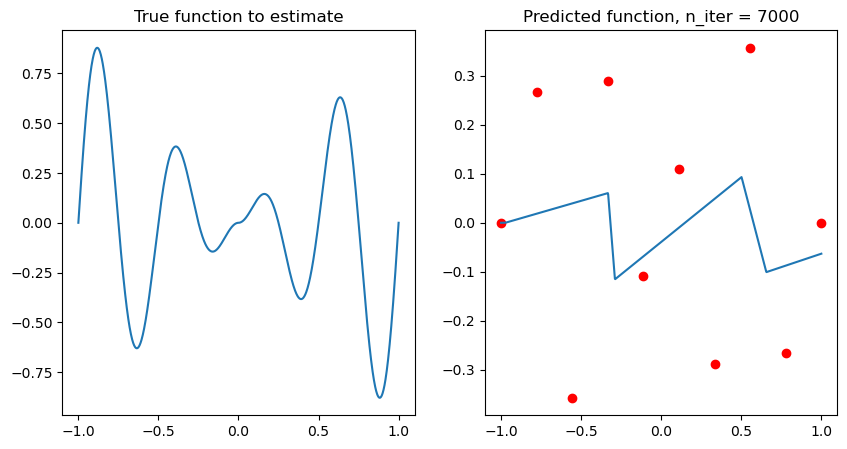

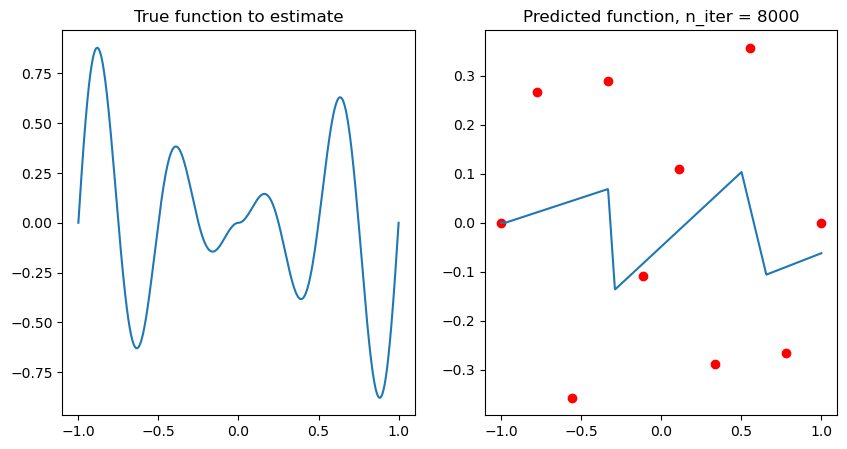

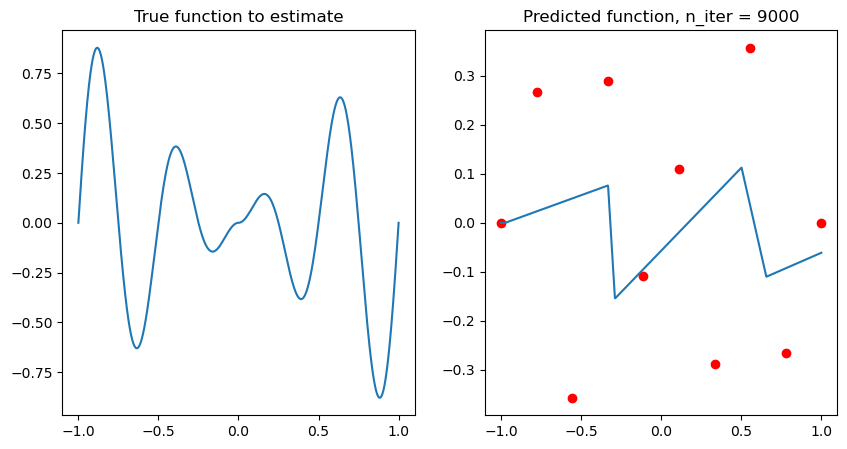

In [178]:
regime(5)

  0%|          | 0/10000 [00:00<?, ?it/s]

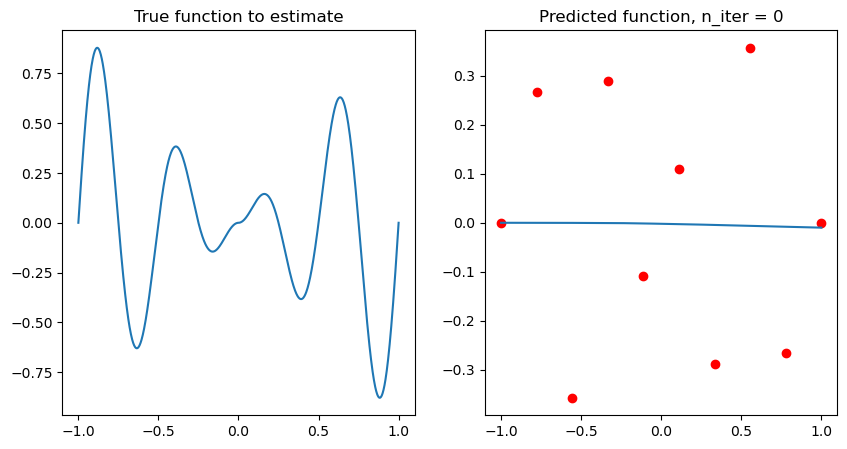

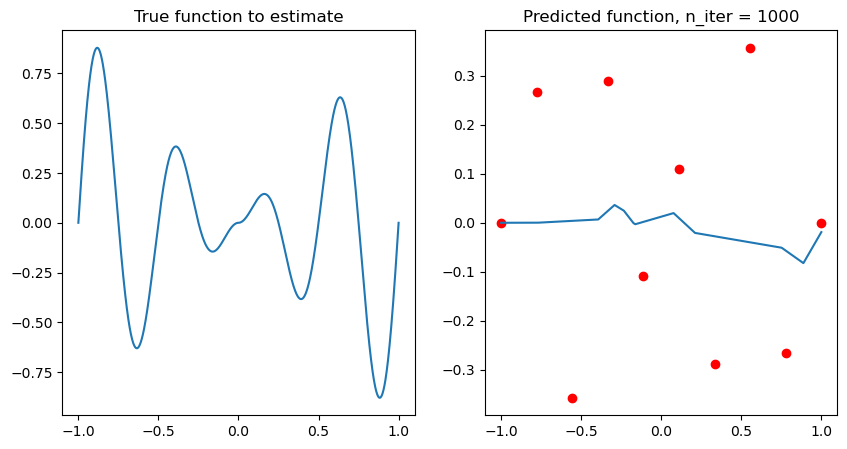

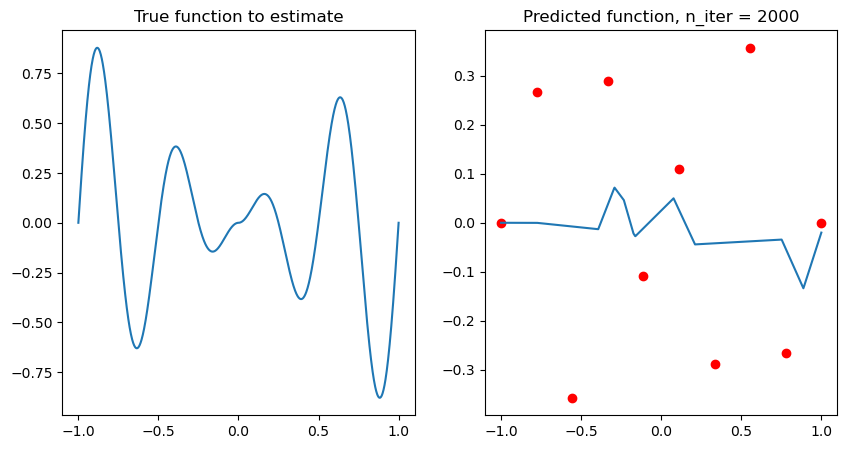

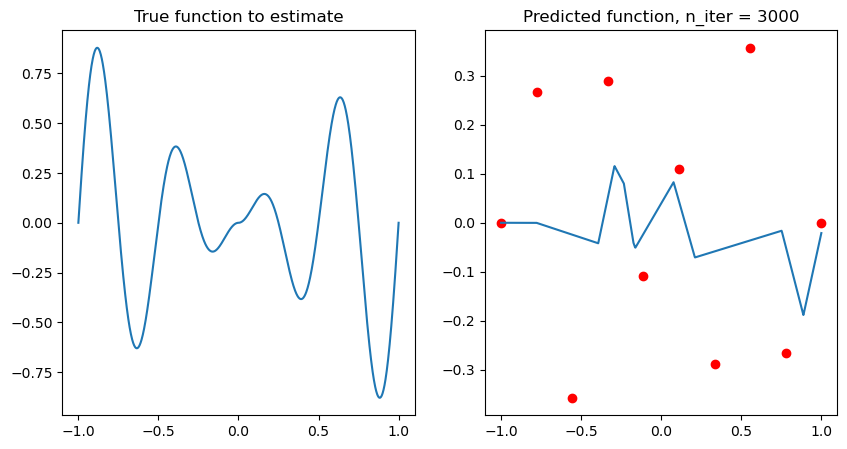

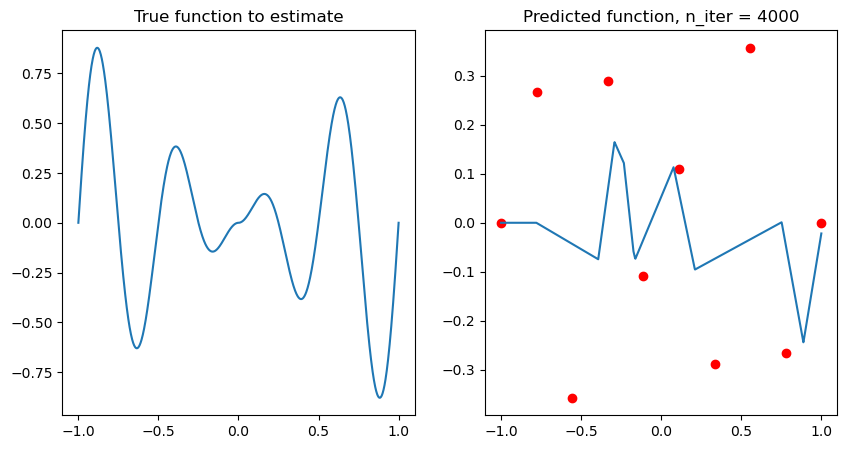

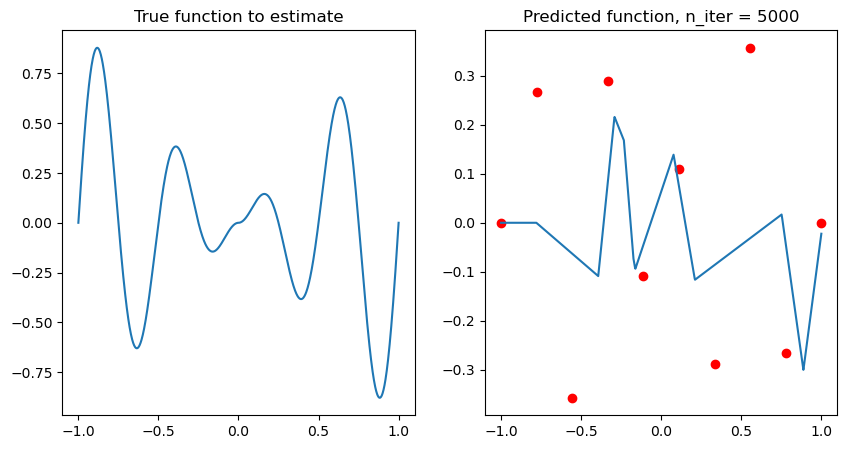

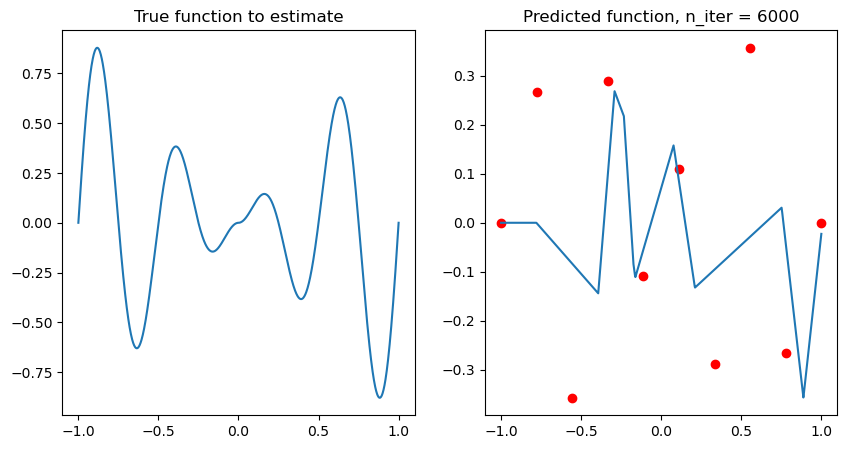

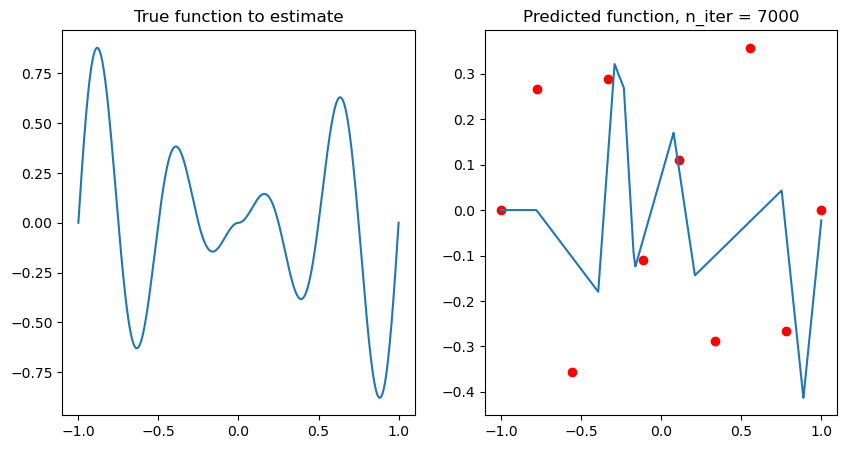

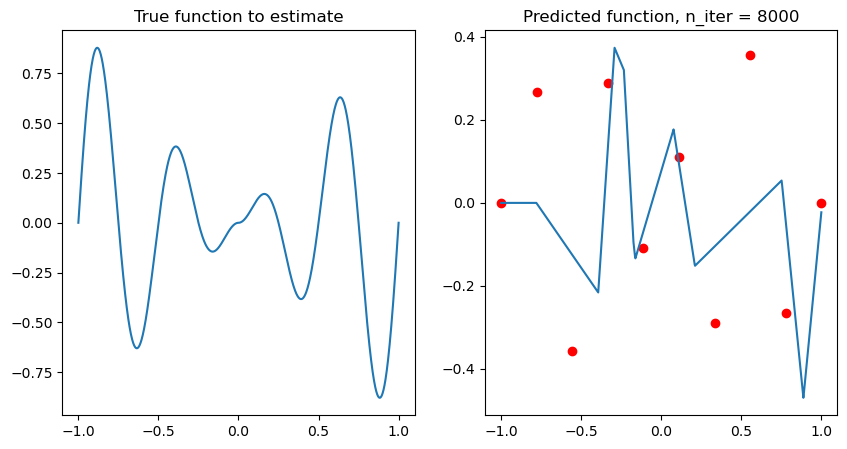

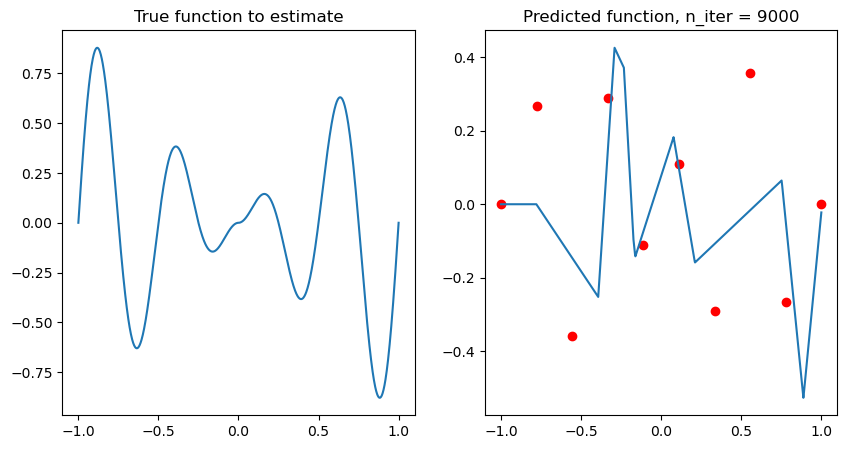

In [179]:
regime(10)

## Régime limite

  0%|          | 0/10000 [00:00<?, ?it/s]

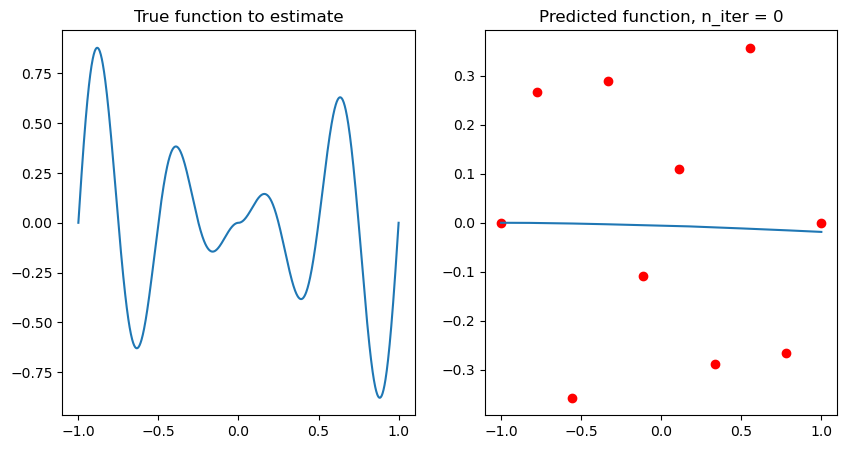

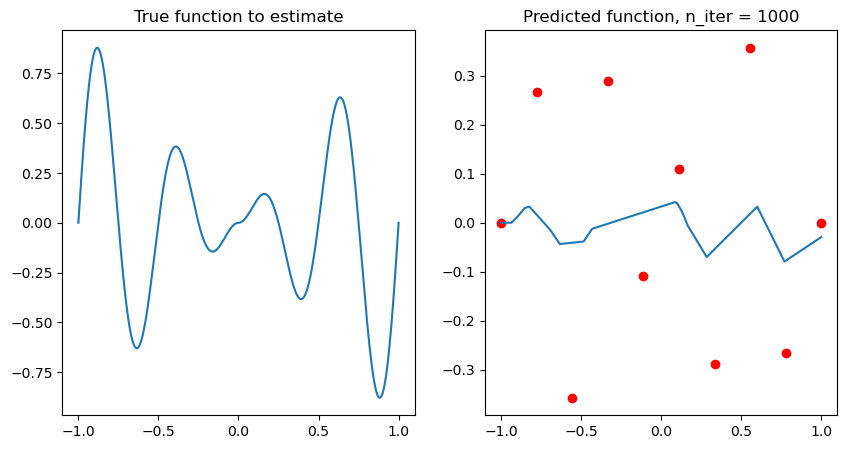

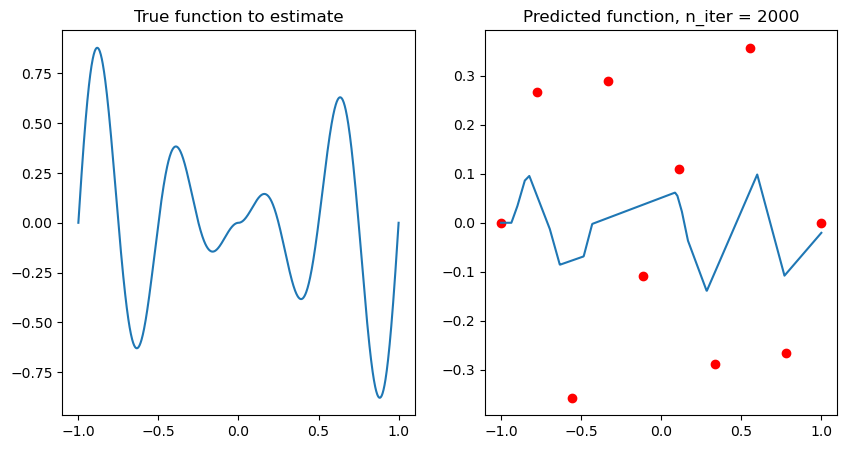

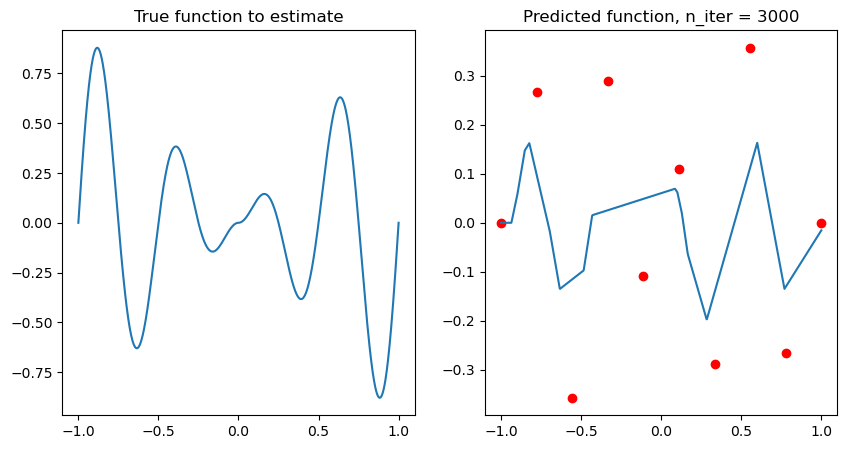

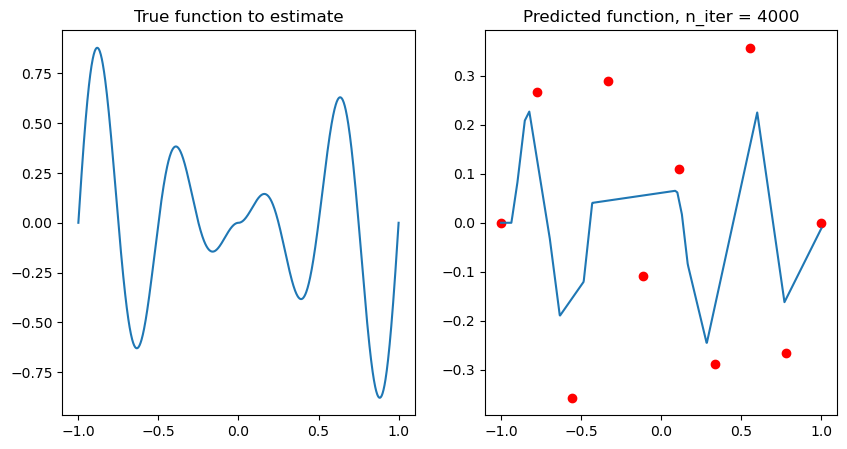

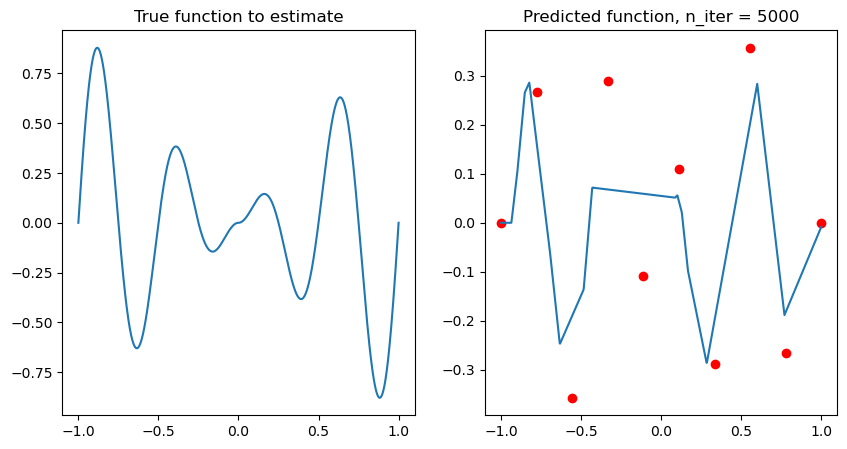

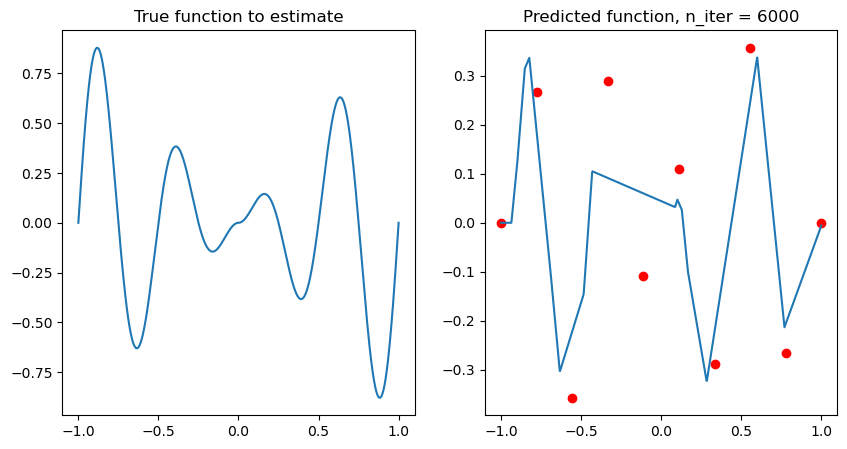

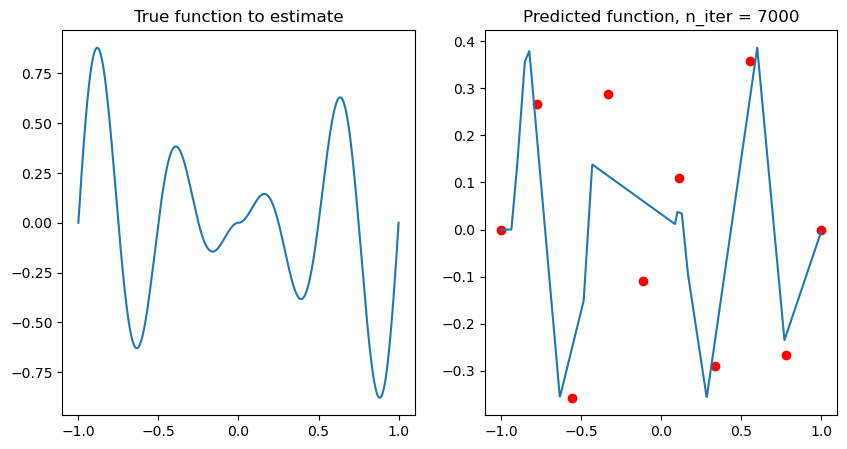

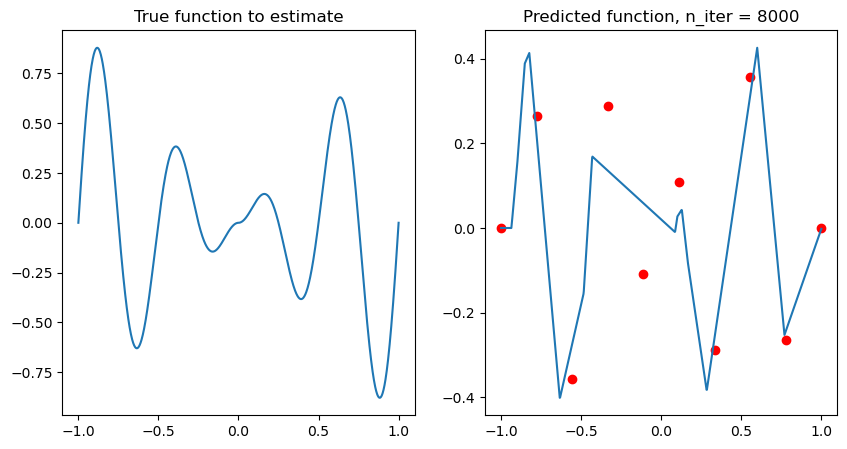

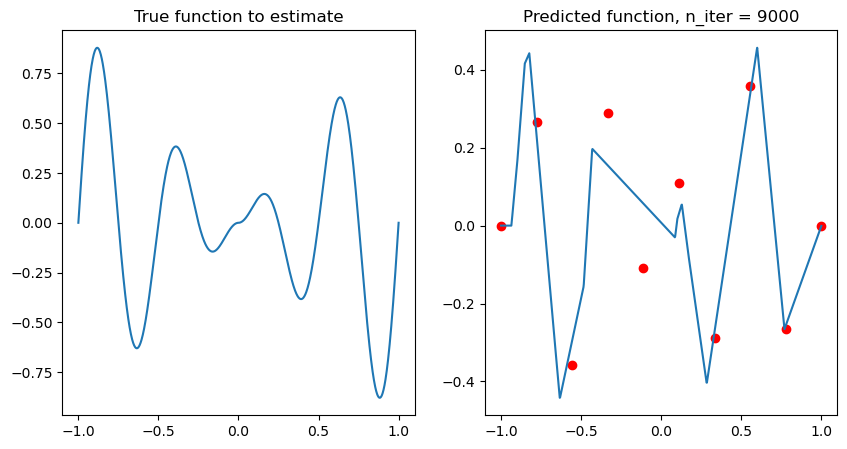

In [180]:
regime(15)

  0%|          | 0/10000 [00:00<?, ?it/s]

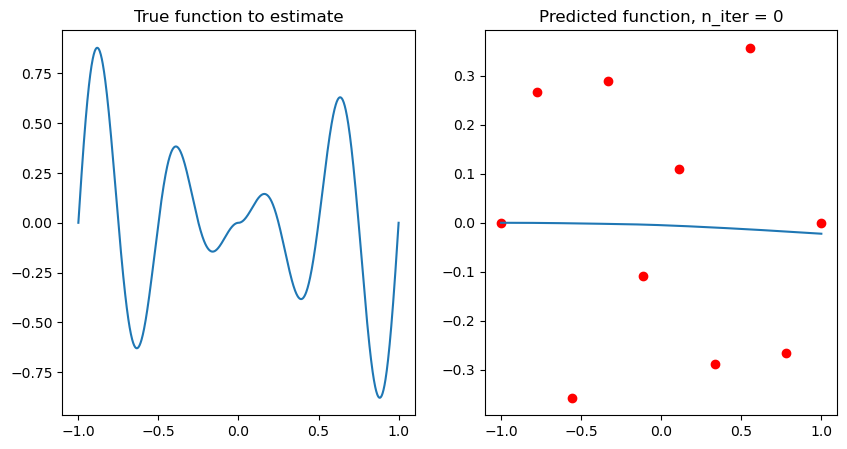

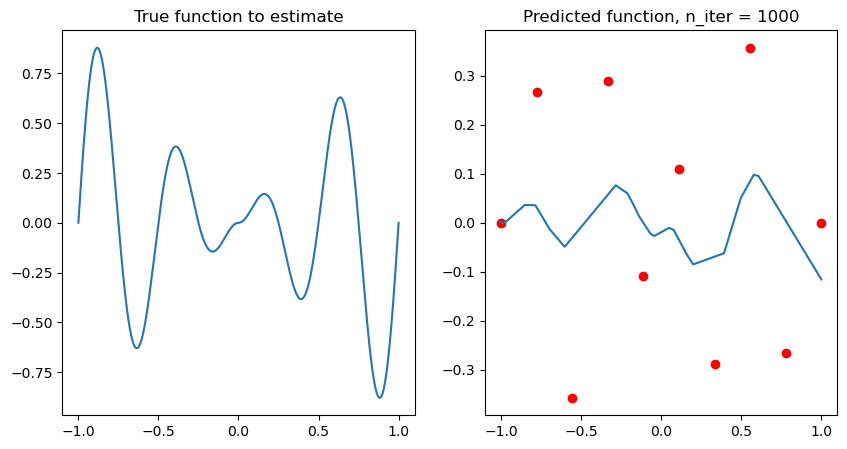

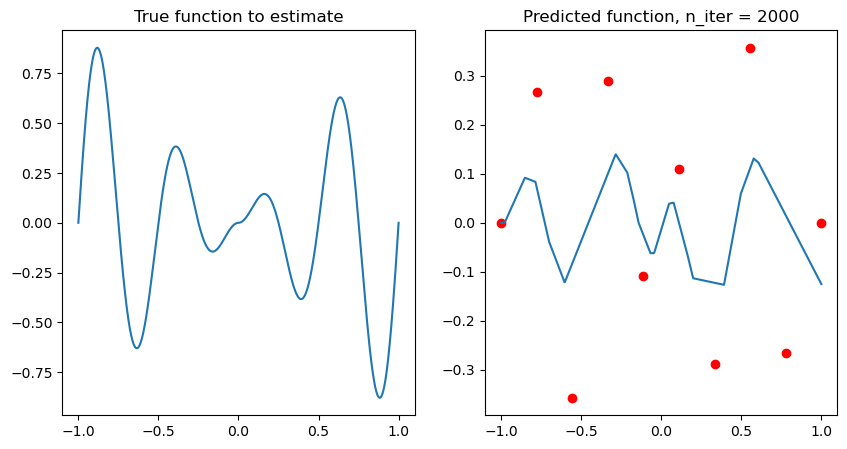

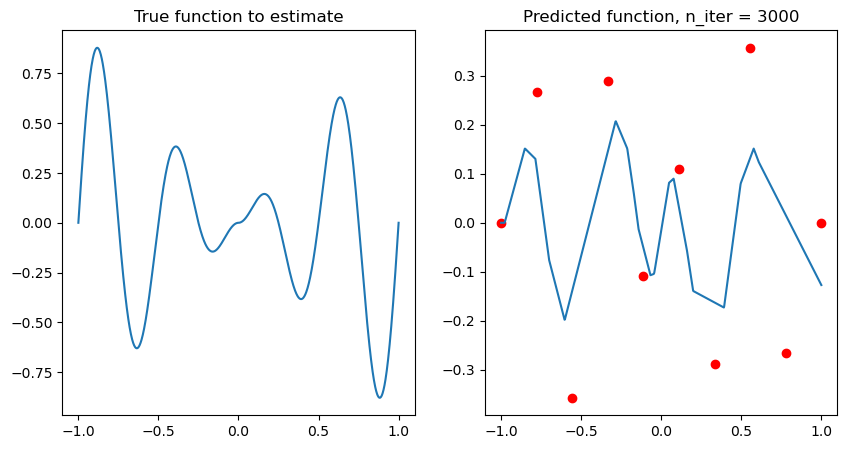

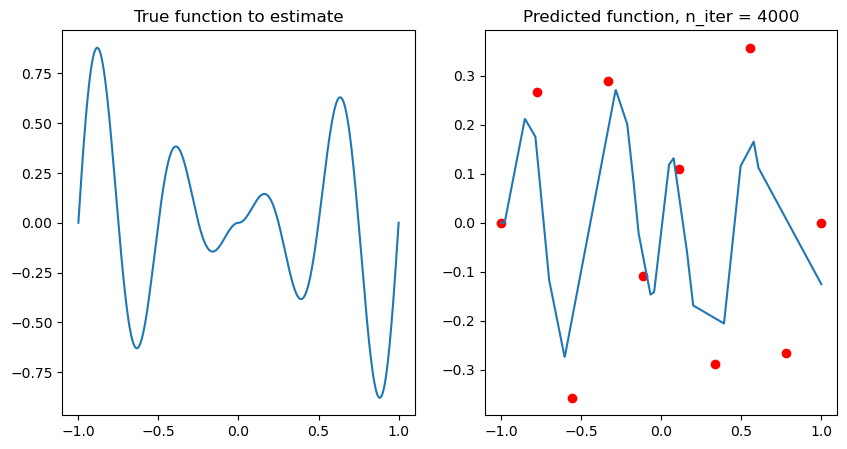

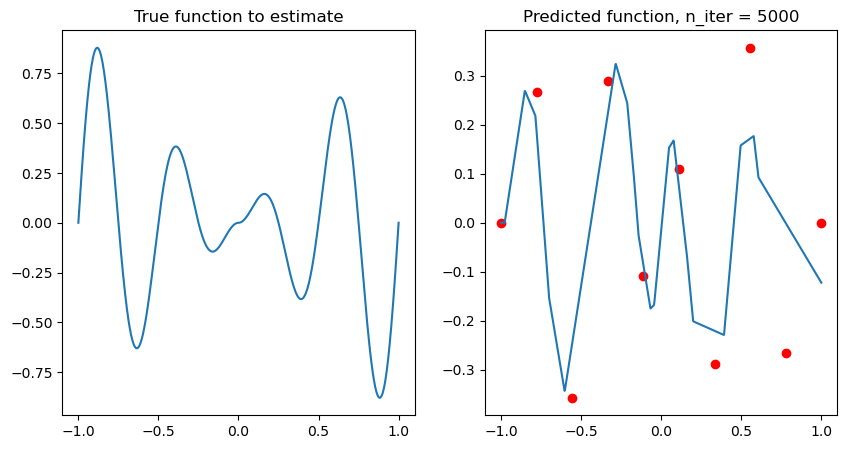

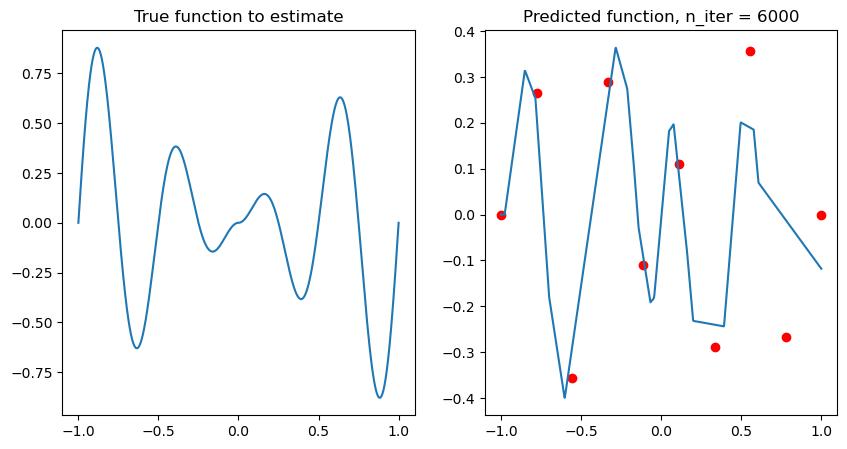

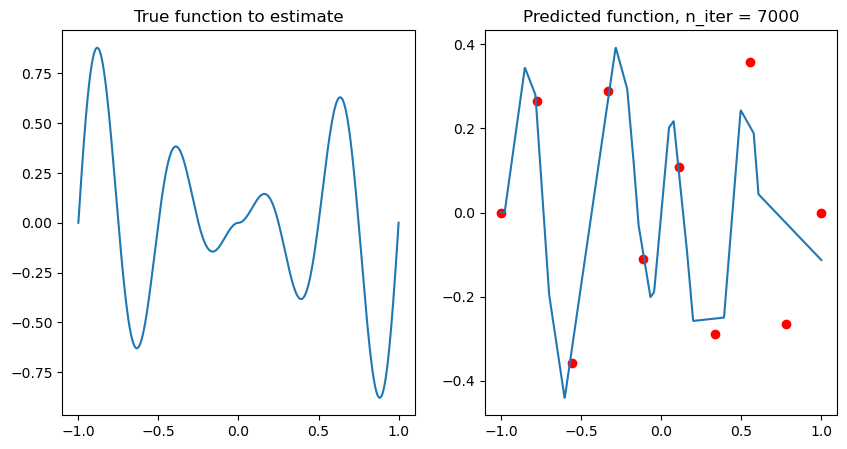

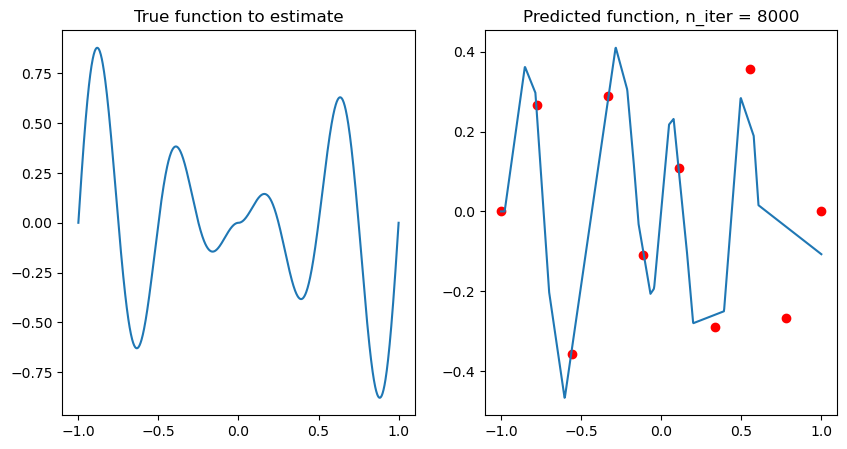

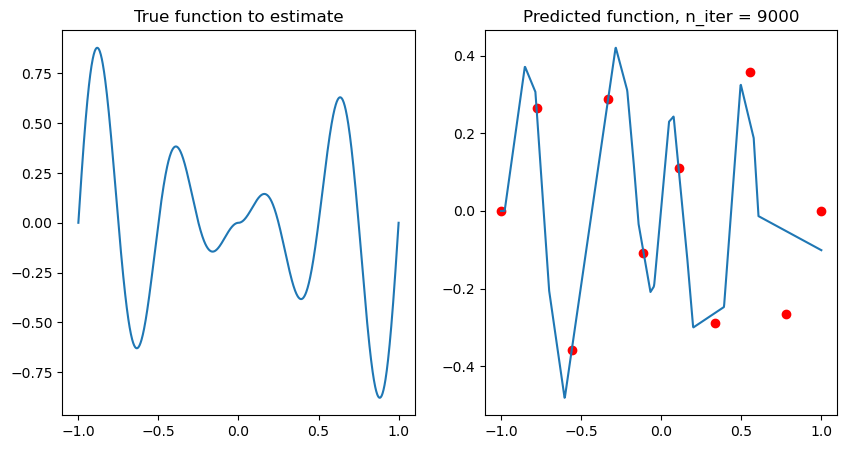

In [181]:
regime(20)

  0%|          | 0/10000 [00:00<?, ?it/s]

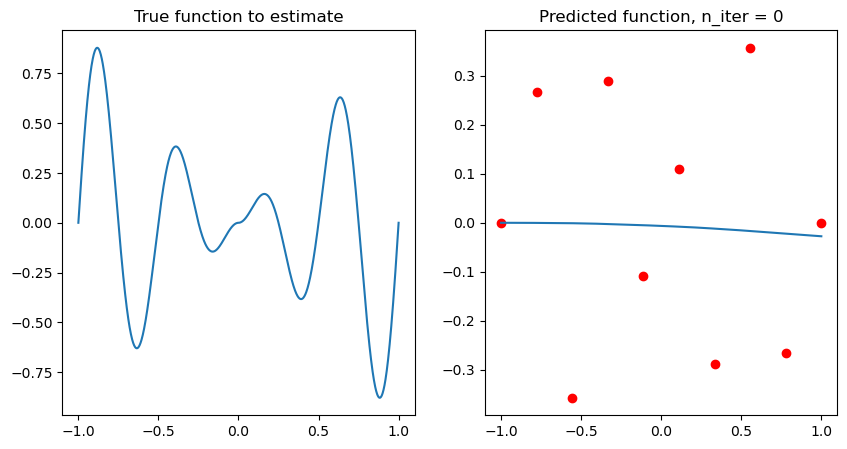

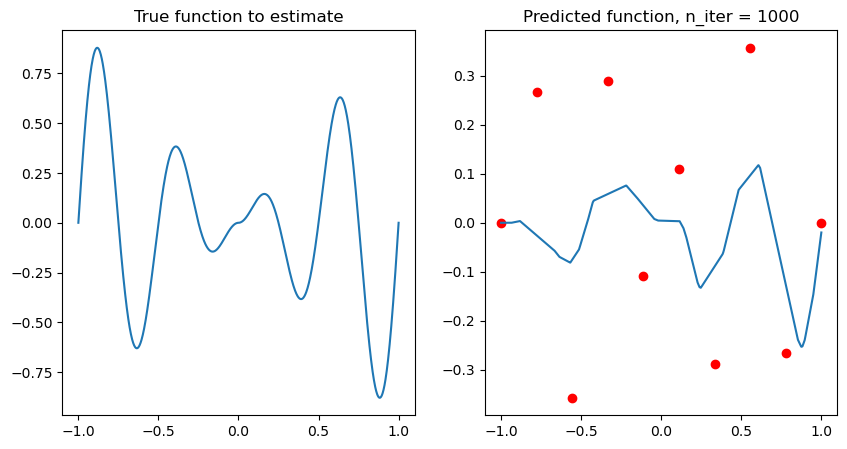

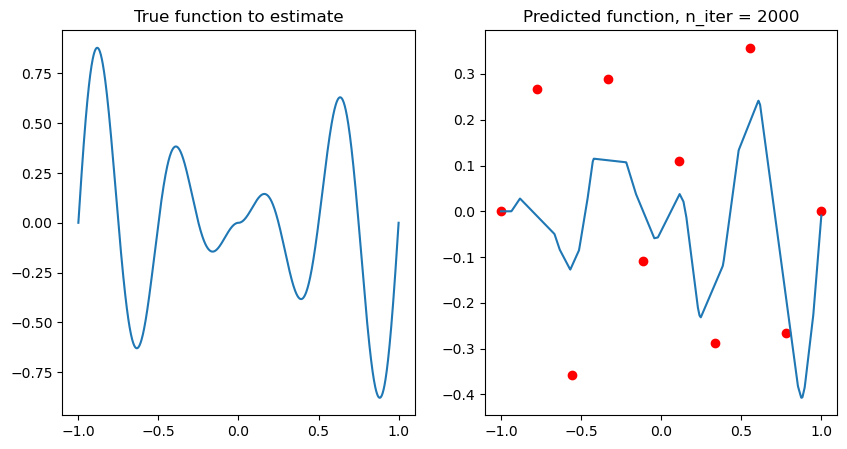

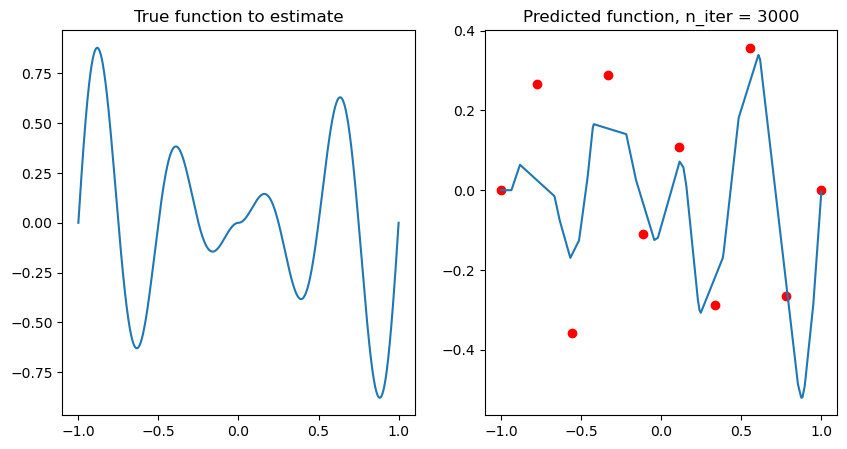

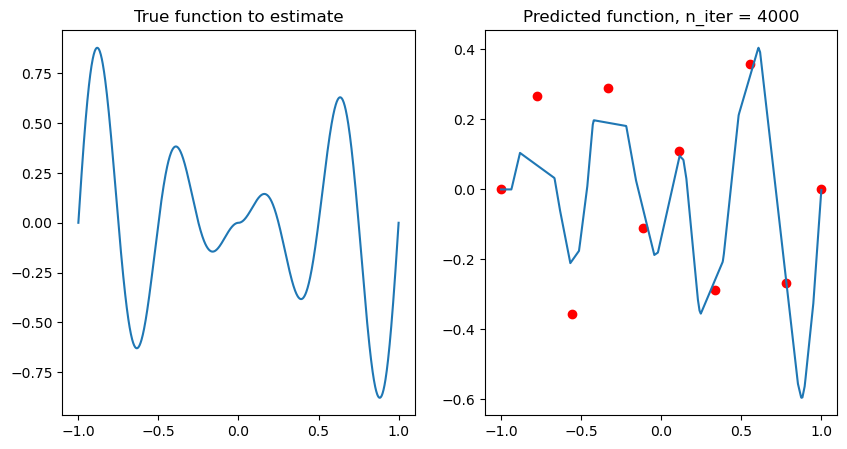

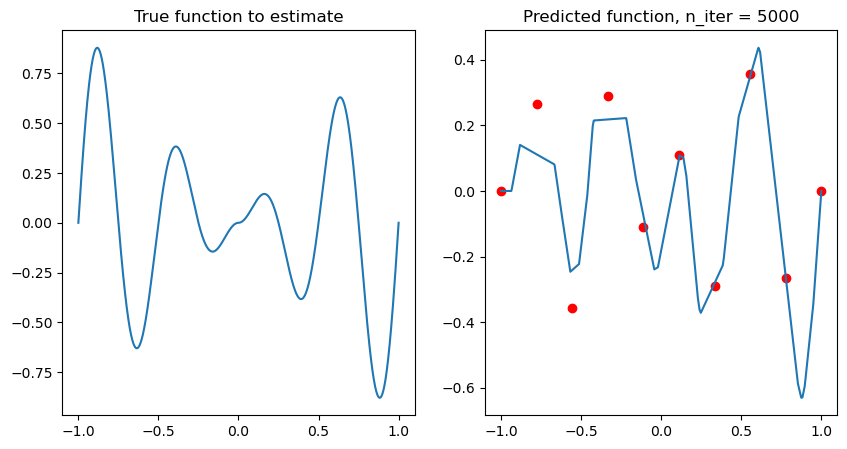

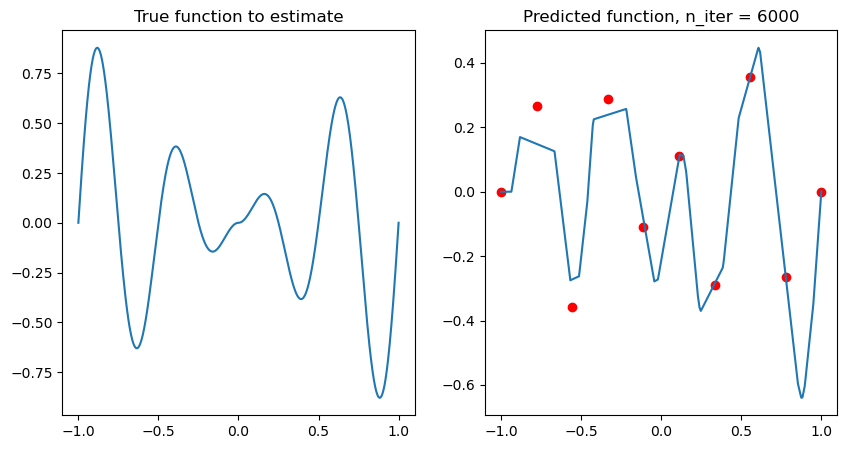

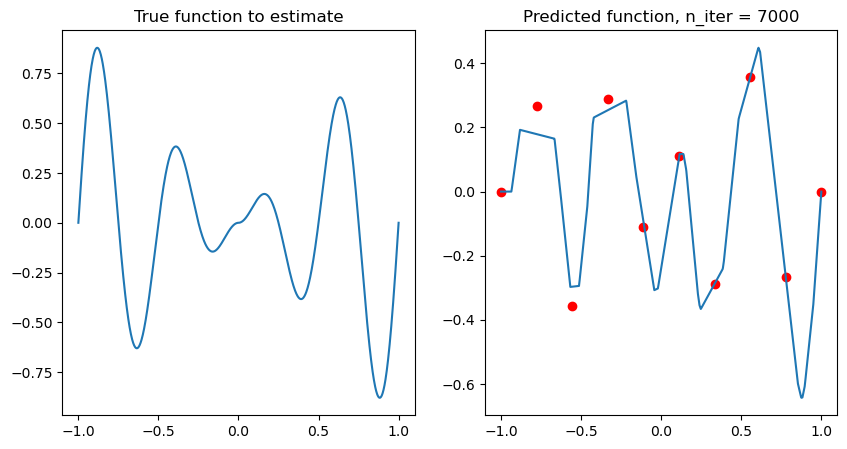

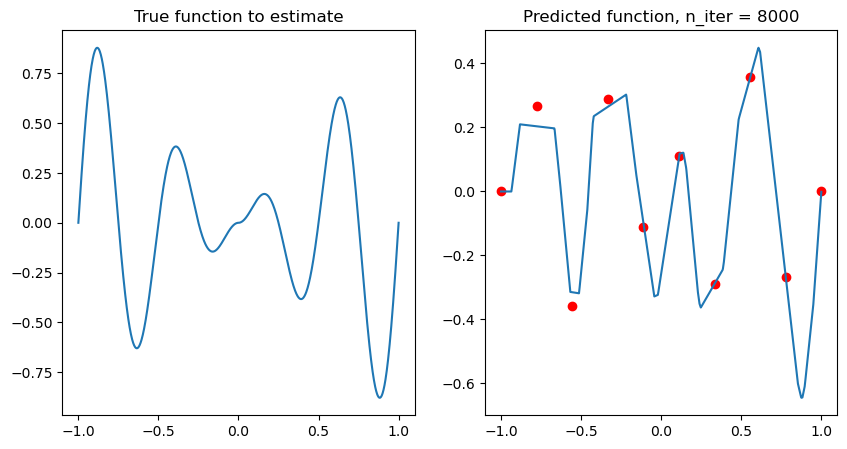

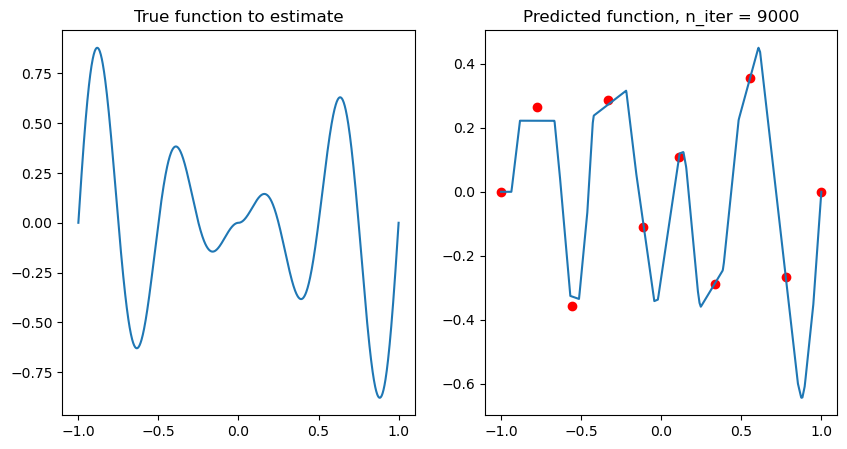

In [182]:
regime(30)

## Régime sur-paramétré

  0%|          | 0/10000 [00:00<?, ?it/s]

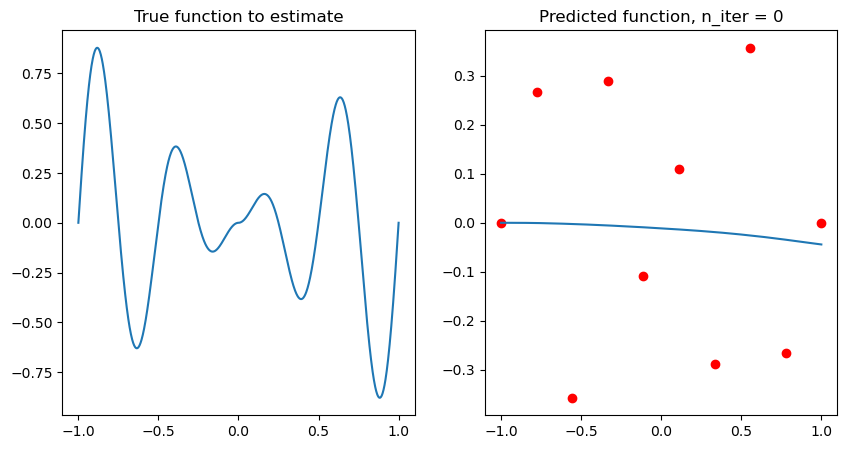

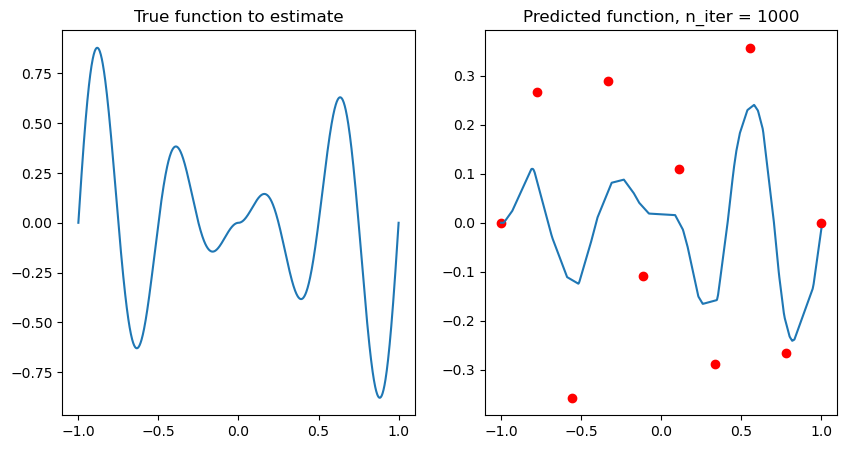

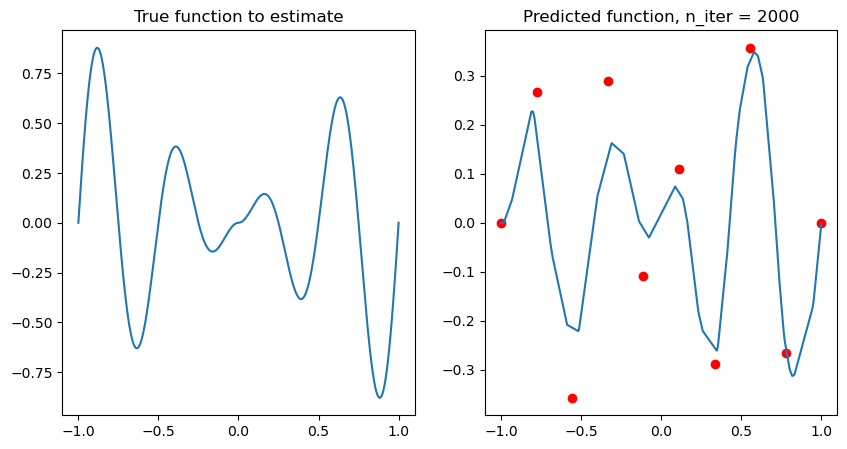

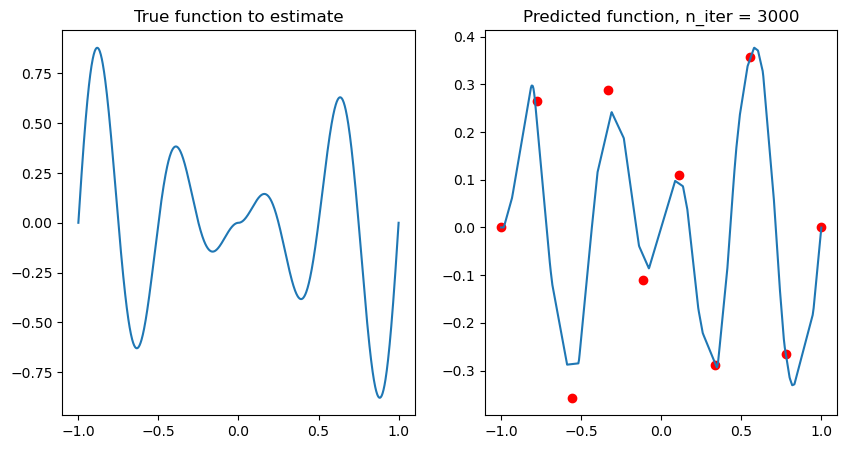

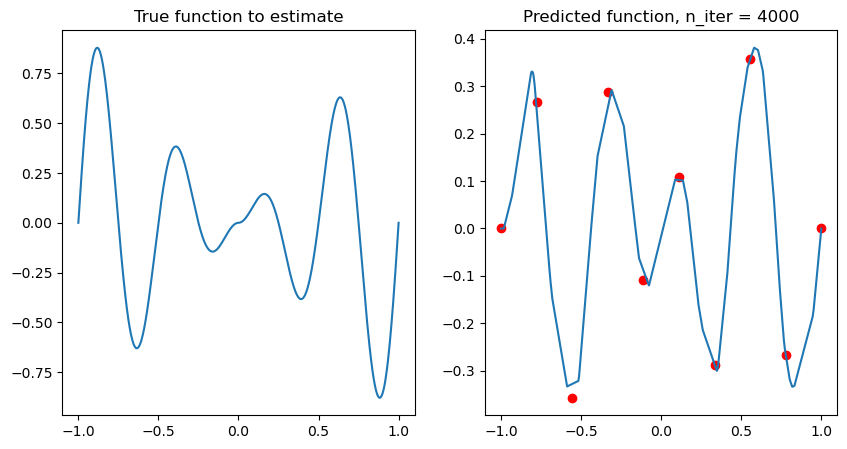

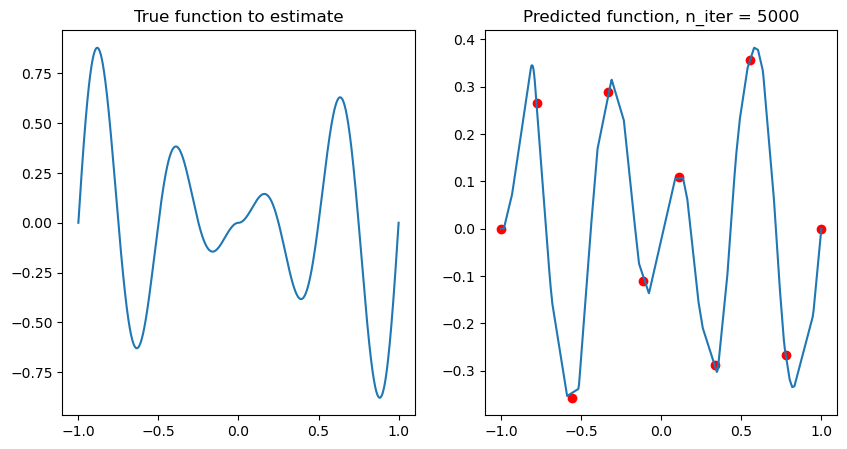

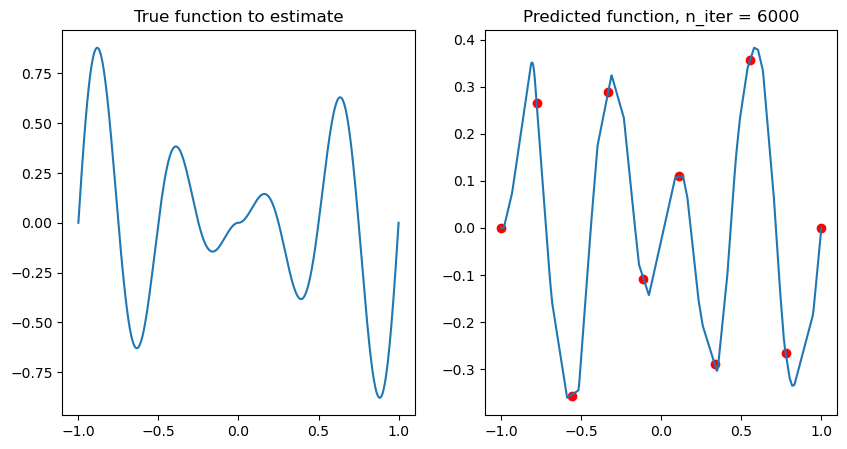

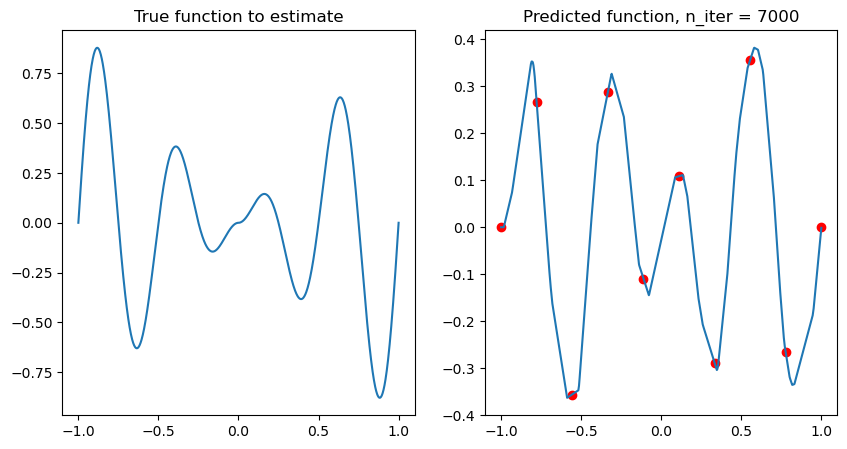

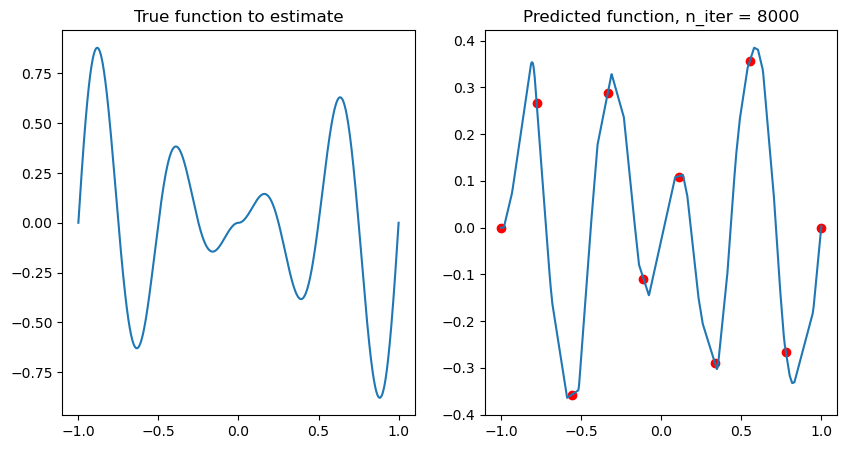

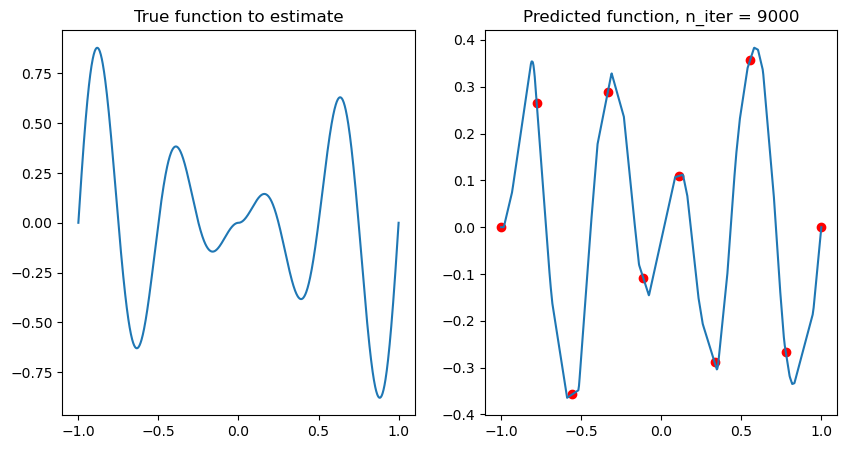

In [183]:
regime(50)

  0%|          | 0/10000 [00:00<?, ?it/s]

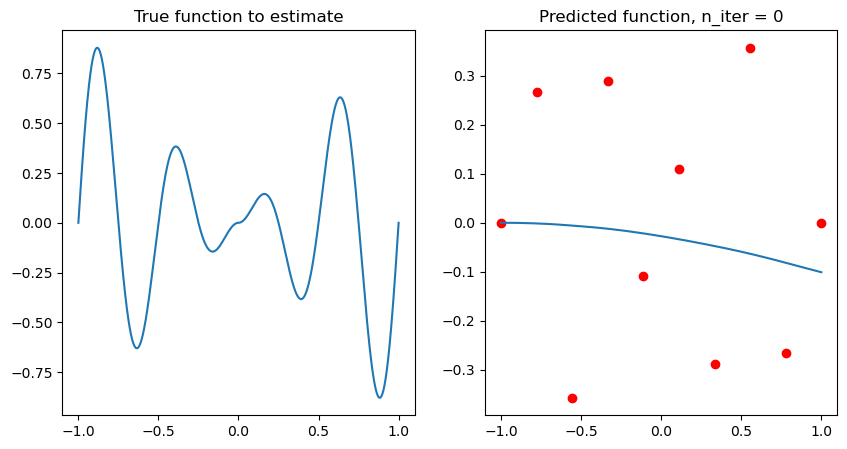

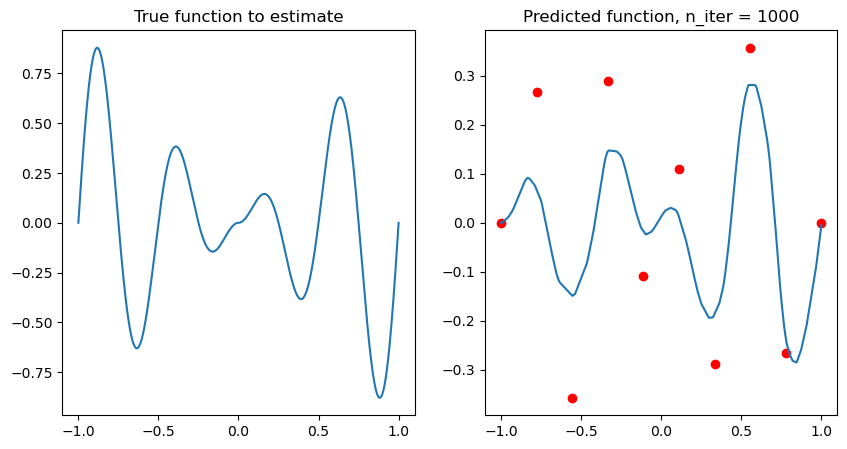

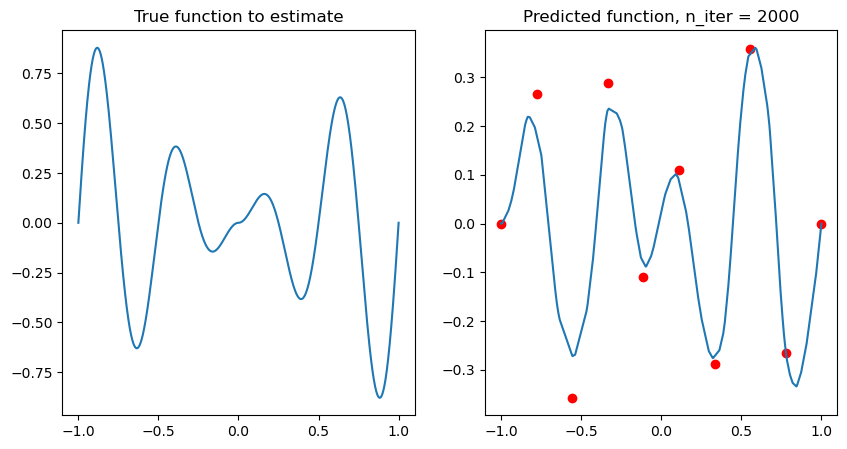

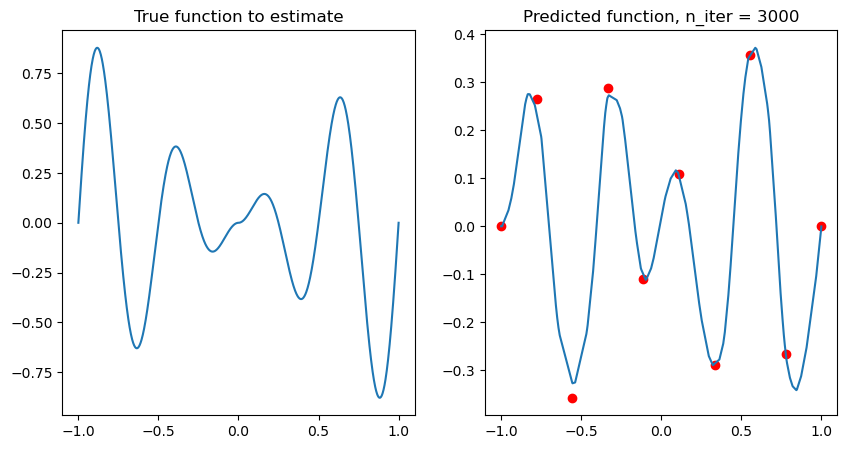

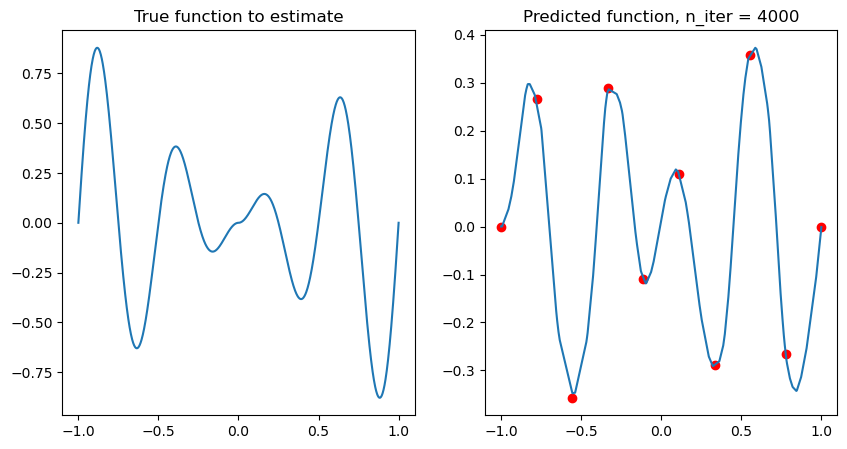

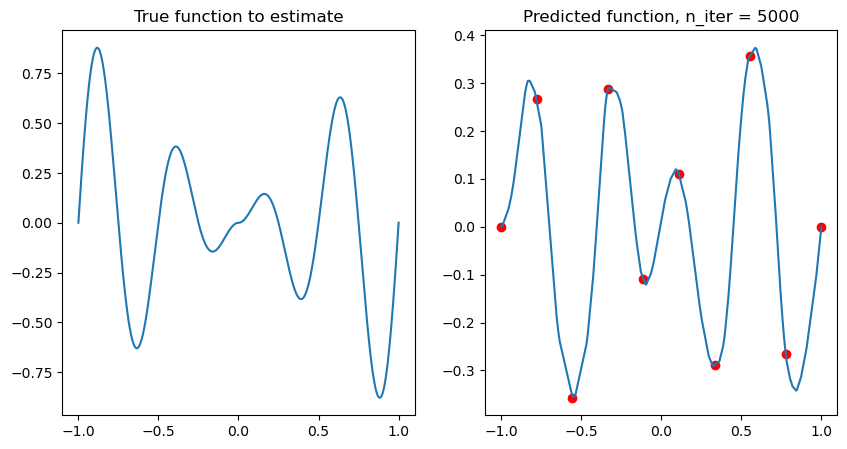

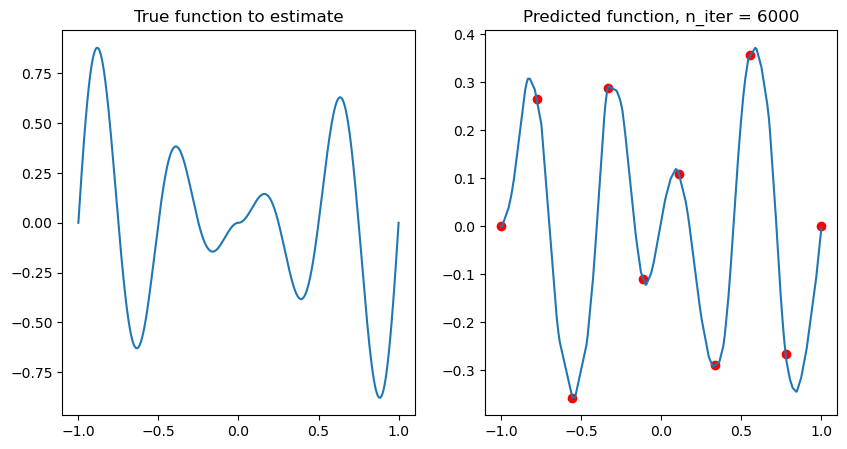

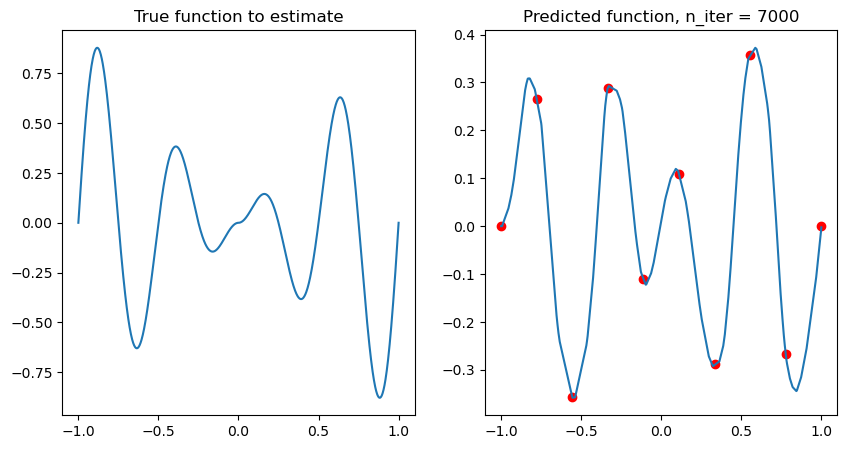

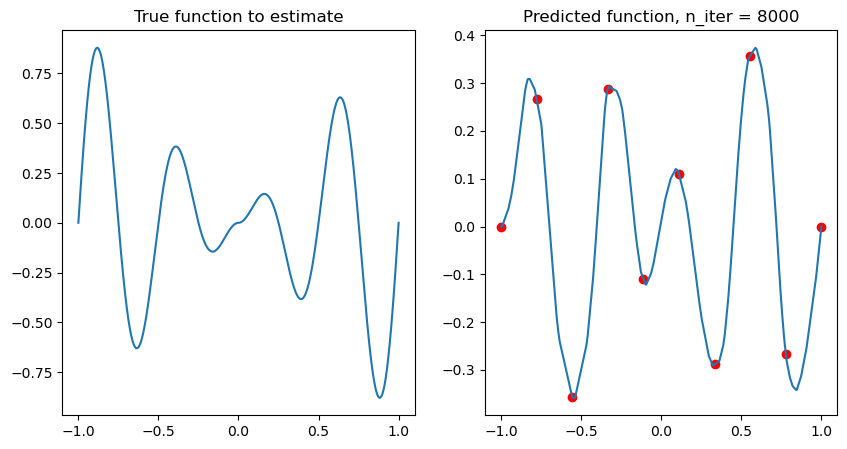

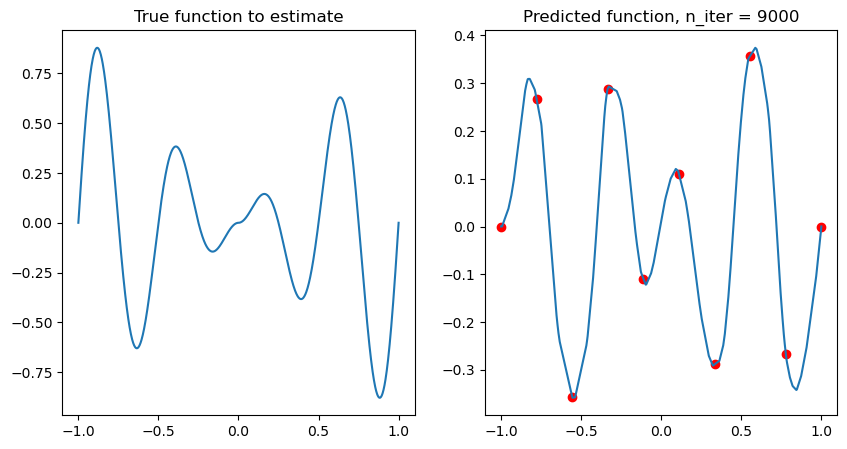

In [184]:
regime(100)

  0%|          | 0/10000 [00:00<?, ?it/s]

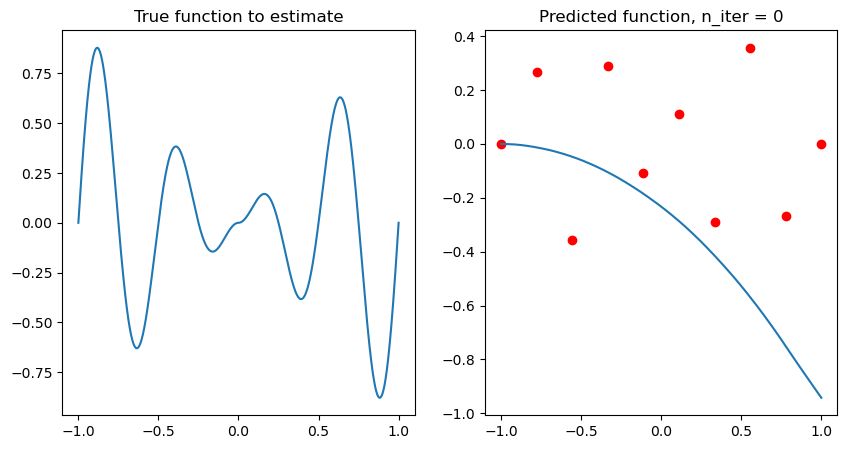

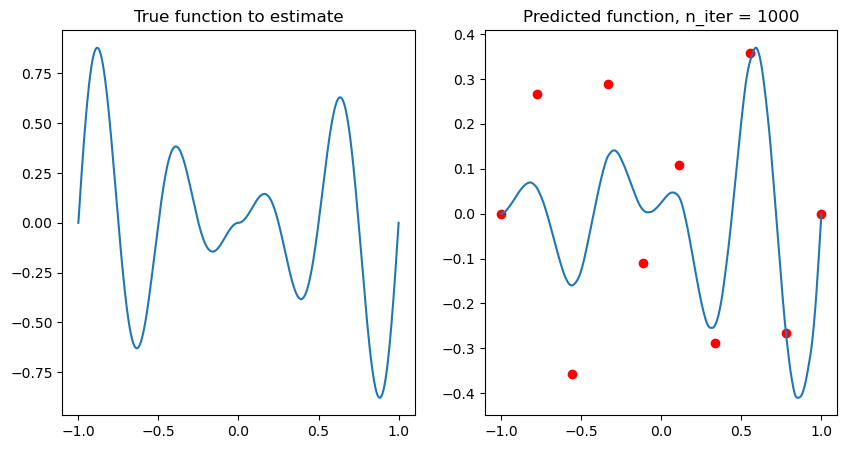

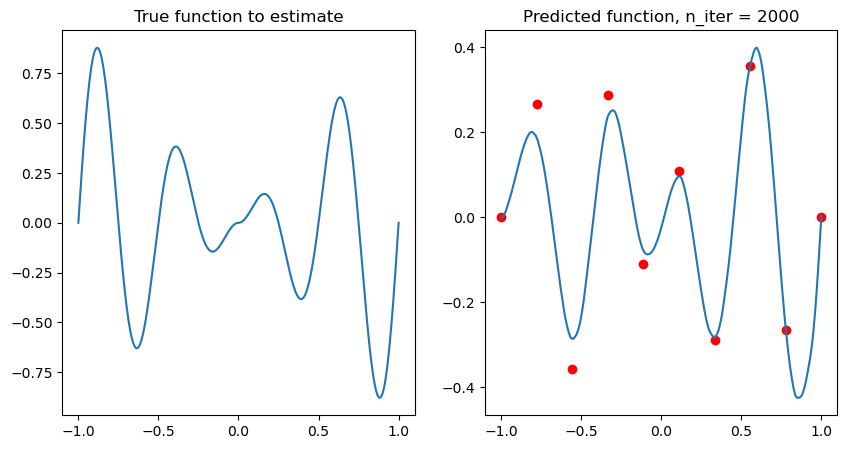

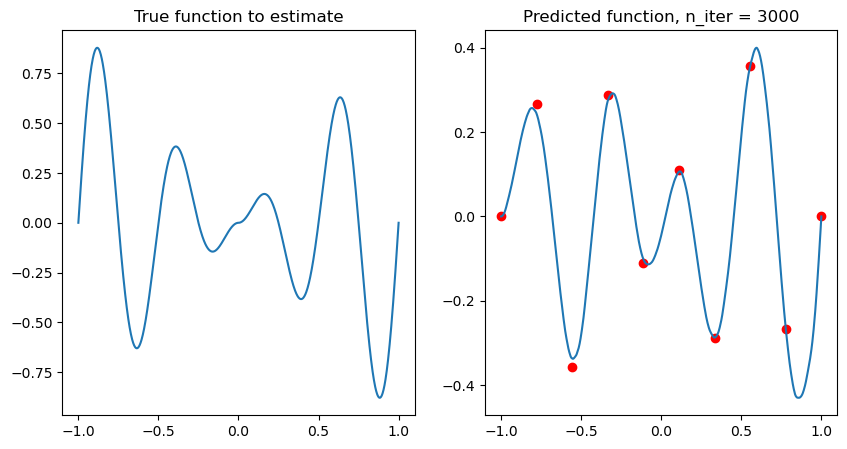

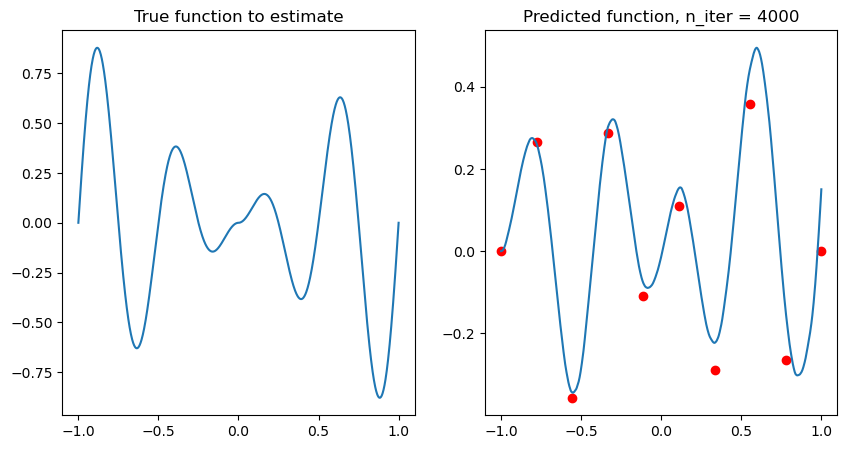

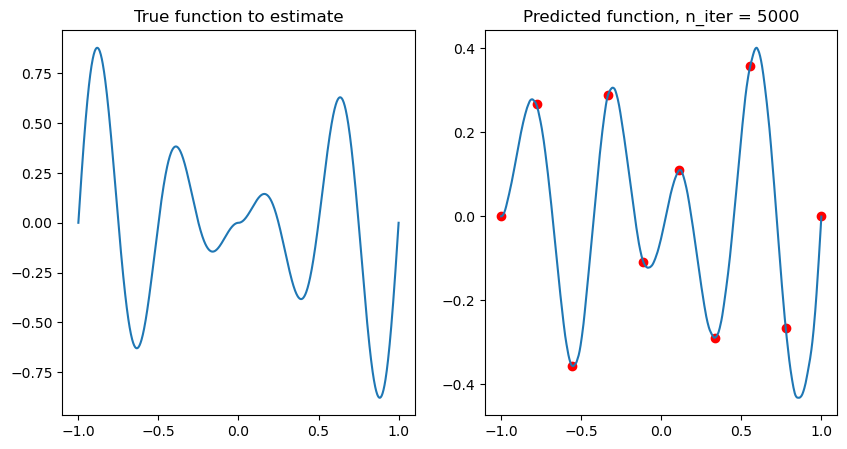

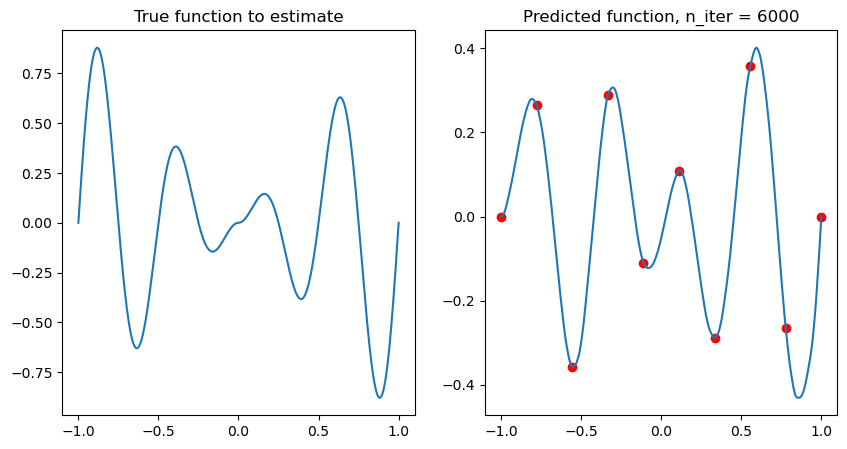

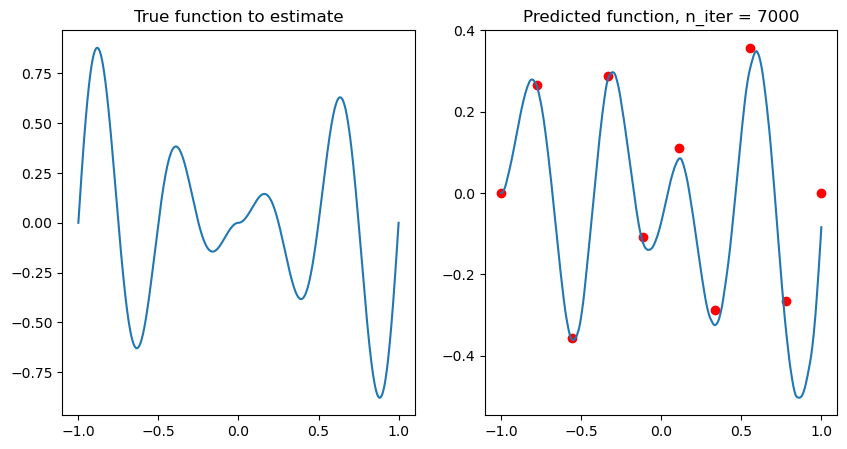

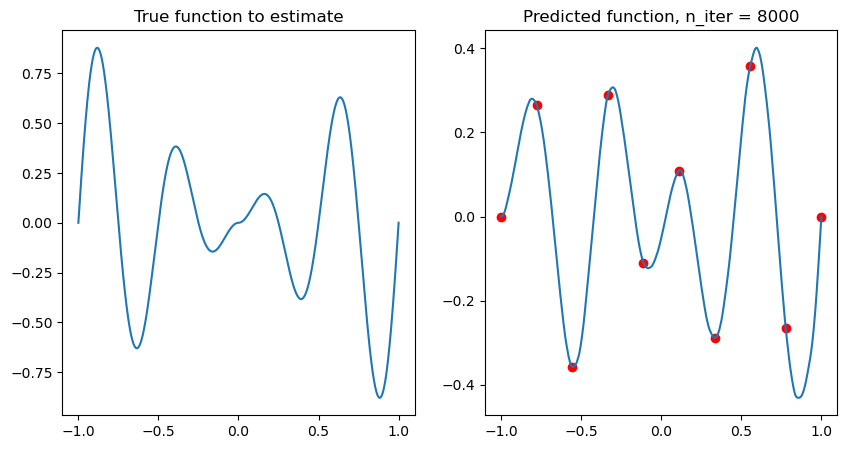

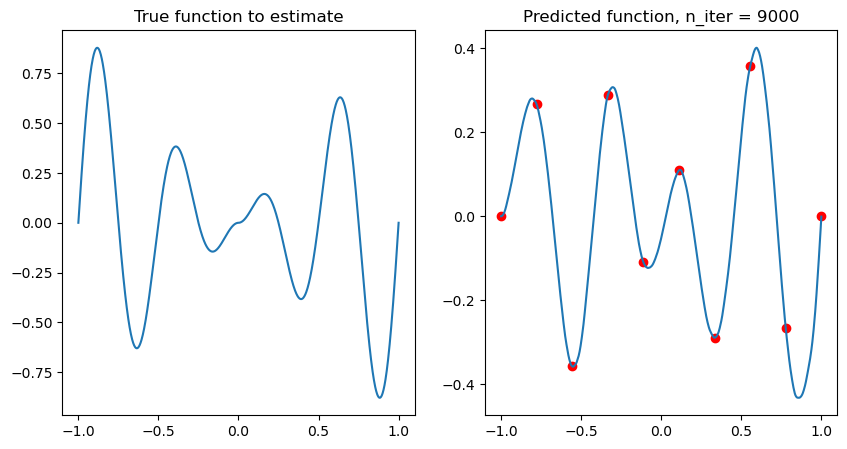

In [185]:
regime(1000)

## Remarques

- Pour le régime sous-paramétré, nous n'avons pas une bonne approximation. En effet, nous avons un résultat très linéaire, non lisse. Le réseau a du mal à apprendre les données car il ne possède pas assez de paramètres.
- Pour le régime limite, nous arrivons à mieux distinguer l'allure de la fonction d'origine au bout d'un certain nombre d'iterations ($\approx$ 10000). Toutefois, nous n'avons toujours pas un résultat lisse. Il faudrait plus de paramètres.
- Pour le régime sur-paramétré, nous avons un résultat très satisfaisant, lisse et qui passe par tout les points initiaux. Le réseau n'approxime pas toute les subtilités de la fonction à estimer comme dit dans la partie précédente.
- Le régime sur-paramétré est le meilleur.

# Analyse du risque moyen

In [114]:
def risque(n_hidden):
    N = 10
    x_test = torch.linspace(-1,1,N)
    y_test = f(x_test)
    model1 = RandomReLU(n_hidden = n_hidden)
    optimizer = optim.Adam(model1.parameters(), lr=0.001, betas=(0.9, 0.999))
    niter_train = 10000
    batch_size = 10
    loss_tracking = []
    t = tqdm(range(niter_train))
    for i in t:
        
        if batch_size>=N:
            x_batch = x_test[:,None] 
            y_batch = y_test[:,]
        else:
            idx = torch.randint(0, len(x_test),(batch_size,))
            x_batch = x_test[idx, None]
            y_batch = y_test[idx, ]

        optimizer.zero_grad()
        y_pred = model1(x_batch)
        loss = torch.mean((y_pred - y_batch)**2)
        #loss = torch.mean(torch.abs(y_pred - y_batch))
        loss.backward()
        optimizer.step()
        loss_tracking.append(loss.item())


    return torch.sum((model1(x_espace[:,None])-f(x_espace))**2).cpu().item()/M #calcul du risque moyen

In [156]:
#boucle pour tester différentes nombres de paramètres
D = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50,70,90,100]
risque_mean = []
for j in range(len(D)):
    risque_mean.append(risque(D[j]))

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

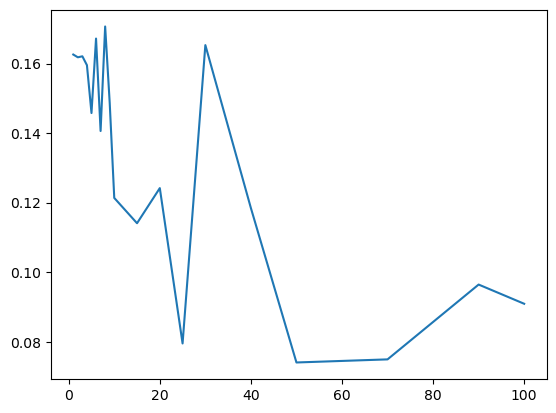

In [157]:
plt.plot(D, risque_mean)

Nous pouvons comparer notre courbe à la "double descent generalization curve" qui indique quand un modèle est surparamétré ou non. On constate notre pic aux alentours des 40 paramètres ce qui veut dire qu'au dessus de cette valeur notre modèle sera surparamétré et on aura un risque qui décroit donc une meilleure approximation.

## Analyse du risque empirique

In [158]:
def risque_emp(n_hidden):
    N = 10
    x_test = torch.linspace(-1,1,N)
    y_test = f(x_test)
    model1 = RandomReLU(n_hidden = n_hidden)
    optimizer = optim.Adam(model1.parameters(), lr=0.001, betas=(0.9, 0.999))
    niter_train = 10000
    batch_size = 10
    loss_tracking = []
    t = tqdm(range(niter_train))
    for i in t:
        
        if batch_size>=N:
            x_batch = x_test[:,None]
            y_batch = y_test[:,]
        else:
            idx = torch.randint(0, len(x_test),(batch_size,))
            x_batch = x_test[idx, None]
            y_batch = y_test[idx, ]

        optimizer.zero_grad()
        y_pred = model1(x_batch)
        loss = torch.mean((y_pred - y_batch)**2)
        #loss = torch.mean(torch.abs(y_pred - y_batch))
        loss.backward()
        optimizer.step()
        loss_tracking.append(loss.item())

    #affichage de la fonction perte
    plt.figure()
    plt.plot(loss_tracking)
    plt.title("Loss function, n_hidden = " + str(n_hidden))

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

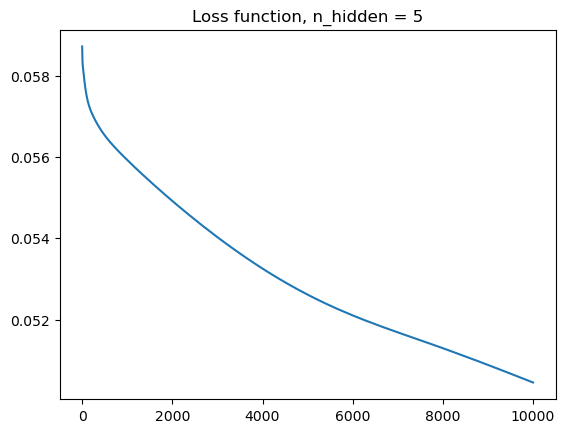

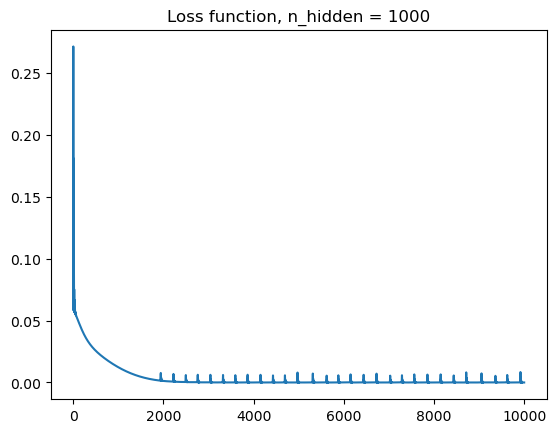

In [159]:
risque_emp(5)
risque_emp(1000)

Nous remarquons une grande différence entre les deux fonctions perte. La première décroit lentement et atteint une valeur de 0.051 au bout de 10000 itérations, contrairement à la seconde qui converge rapidement vers zéro en 2000 itérations. Lorsque le modèle est surparamétré nous arrivons à mieux approximer notre fonction initiale en peu d'itération.

## Amélioration du modèle

Nous pouvons mieux ajuster notre modèle en prenant plus de point iniatiaux, en changeant l'optimiseur (et le learning rate) ou en changeant la fonction perte. Comme on peut le constater ci dessous, nous avons choisi 500 points initiaux et un batch de taille 200. On arrive à mieux approximer les subtilités surtout autour de 0.

In [174]:
def regime_2(n_hidden):
    N = 500
    x_test = torch.linspace(-1,1,N)
    y_test = f(x_test)
    model1 = RandomReLU(n_hidden = n_hidden)
    optimizer = optim.Adam(model1.parameters(), lr=0.001, betas=(0.9, 0.999))
    niter_train = 10000
    batch_size = 200
    loss_tracking = []
    t = tqdm(range(niter_train))
    for i in t:
        
        if batch_size>=N:
            x_batch = x_test[:,None] 
            y_batch = y_test[:,]
        else:
            idx = torch.randint(0, len(x_test),(batch_size,))
            x_batch = x_test[idx, None]
            y_batch = y_test[idx, ]

        optimizer.zero_grad()
        y_pred = model1(x_batch)
        loss = torch.mean((y_pred - y_batch)**2)
        loss.backward()
        optimizer.step()
        loss_tracking.append(loss.item())

        if i% 1000 == 0:
            with torch.no_grad():
                fig, axs = plt.subplots(1, 2, figsize=(10,5))
                axs[0].plot(x_espace.cpu().numpy(), f(x_espace).cpu().numpy())
                axs[0].set_title("True function to estimate")
                axs[1].plot(x_espace.cpu().numpy(), model1(x_espace[:,None]).cpu().numpy())
                axs[1].scatter(x_batch.cpu().numpy(), y_batch.cpu().numpy(), color='red')
                axs[1].set_title("Predicted function, n_iter = " + str(i))
                plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

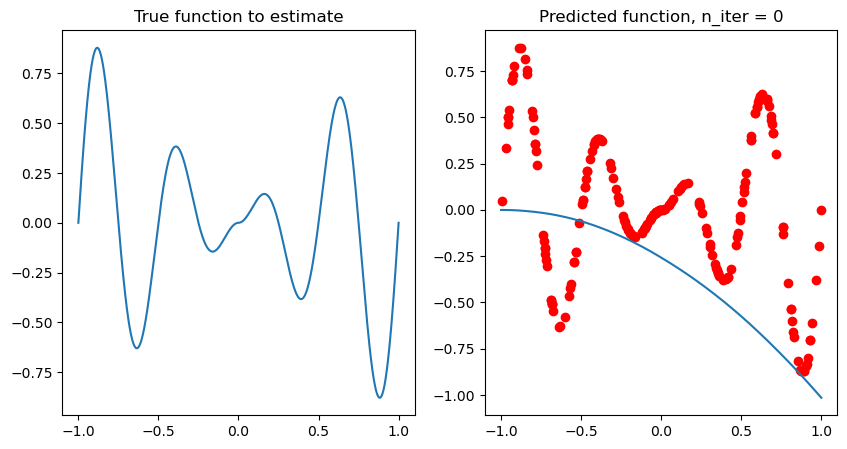

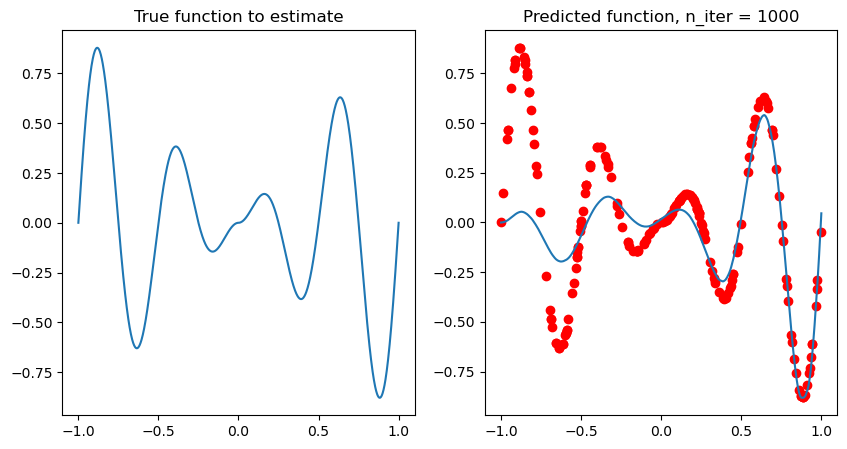

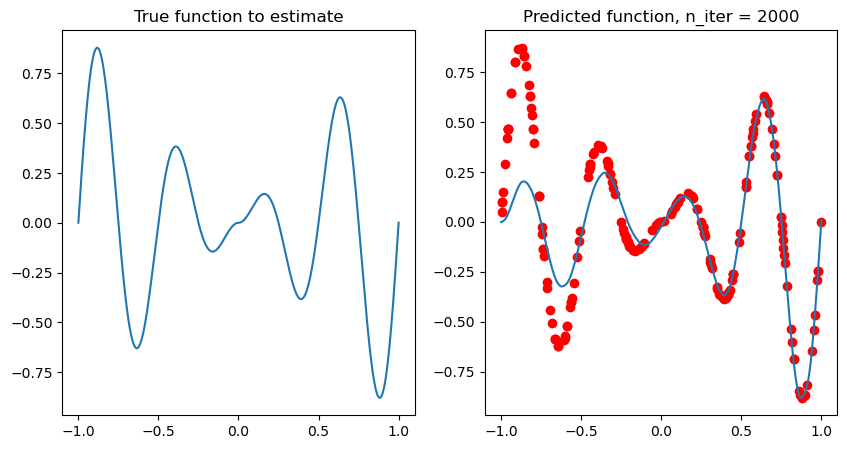

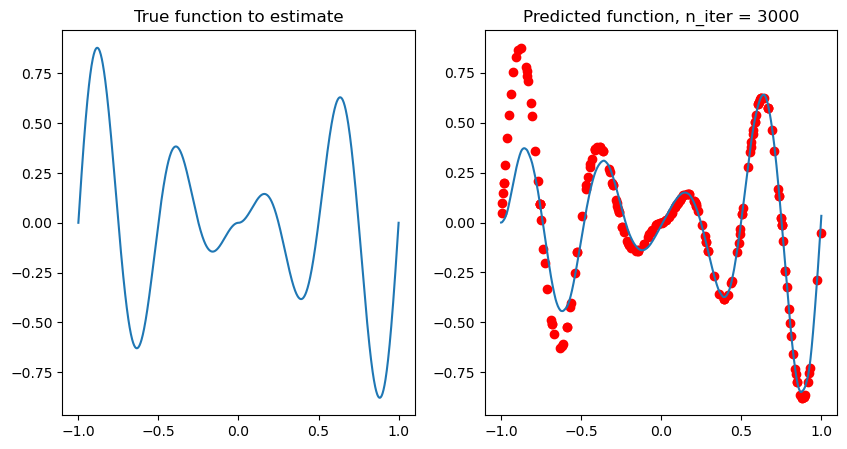

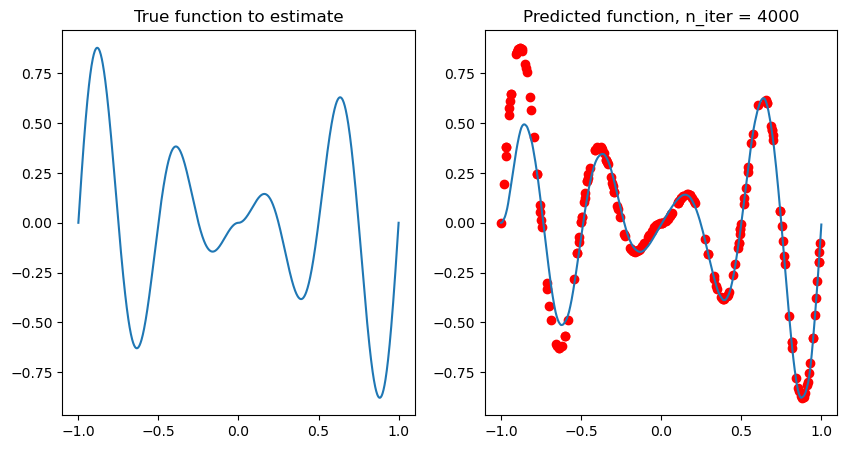

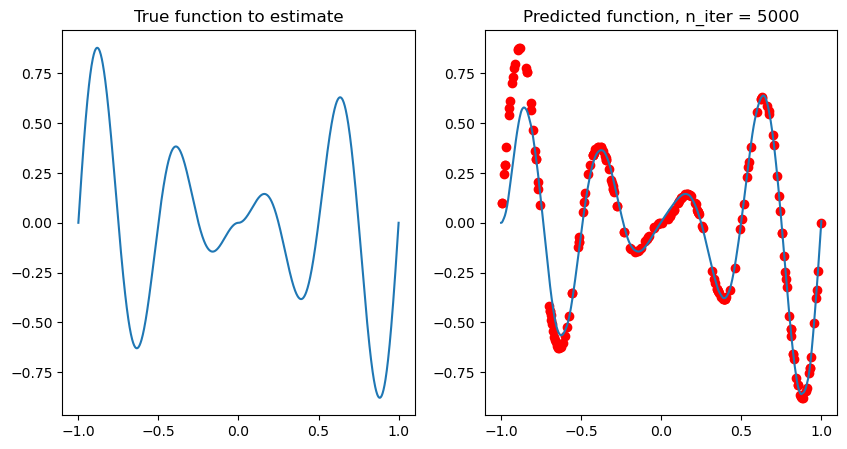

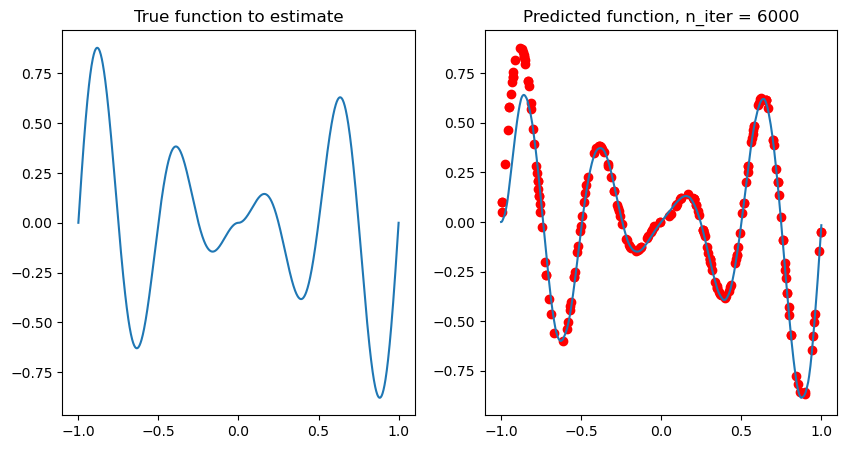

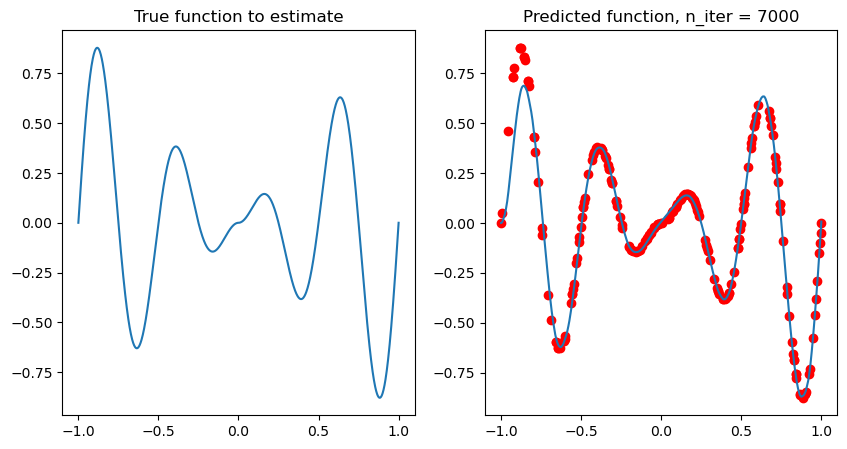

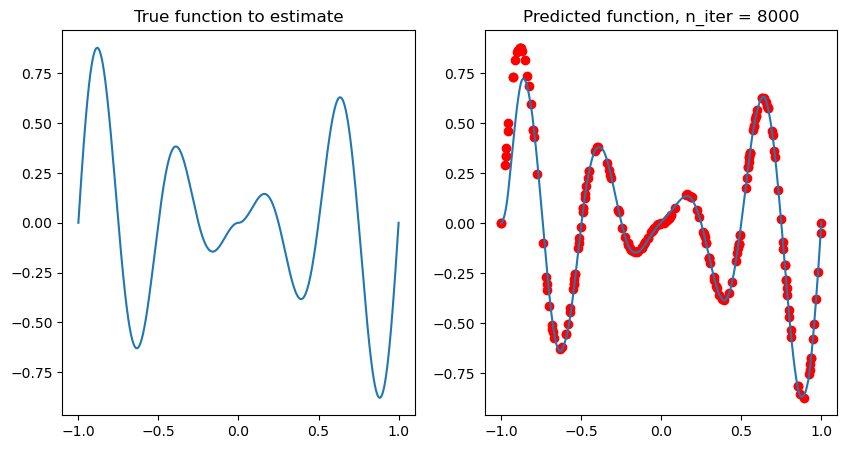

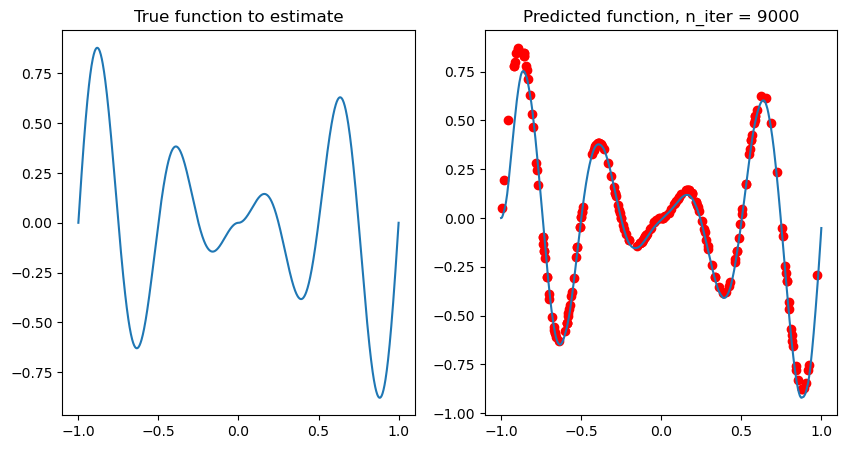

In [175]:
regime_2(1000)